In [1]:
#import needed library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime
import numpy as np
from pandas import DataFrame
from typing import List
from scipy.stats import skew
import pingouin as pg

#### The following functions is for cleaning , transformation and feature engineering

In [2]:
def change_date_time(df:DataFrame,column:str)->DataFrame:
    '''
  This Functions aims to change and transform the datetime column

  Args:
    - df : Pandas DataFrame
    - col: (str) The name of the column needs to be changed
    
  Return:
    - Returns Pandas DataFrame with the Adjusted Info
  '''
    # df[column]=[x.replace(',','-')for x in df[column]]
    df[column]=pd.to_datetime(df[column],format="%H:%M:%S %y,%d,%m")
    # .dt.strftime("%Y-%m-%d %H:%M:%S")
    return df
    

In [3]:
def time_category(column:int)->str:
    '''
  This Functions aims to categories the time of the day

  Args:
    - col: (str) The name of the column that will be categories

  Return:
    - Returns String of the categories time
  '''
    if 0 <= column < 12:
        return 'Morning'
    elif 12 <= column < 18:
        return 'Afternoon'
    else:
        return 'Night'


In [4]:
def create_columns(df:DataFrame,column:str)->DataFrame:
    '''
  This Functions aims to create new columns 

  Args:
    - df : Pandas DataFrame
    - col: (str) The name of the column that will create other info. from it 
  Return:
    - Returns Pandas DataFrame with the Adjusted Info
  '''
    df['Day']=df[column].dt.day_name()
    df['Quarter']=df[column].dt.quarter
    df["Hour"] = df[column].dt.hour
    df['Weekend']=['Weekend' if x=='Friday' or x=='Saturday' else 'Not Weekend' for x in df['Day']]
    df['Time Category']=df['Hour'].apply(time_category)
    df['Month'] = df[column].dt.month_name()
    df['Date'] = df[column].dt.date
    return df

In [5]:
def rename_column_KW(df:DataFrame)->DataFrame:
  '''
  This Functions aims to change column name

  Args:
    - df : Pandas DataFrame
  Return:
    - Returns Pandas DataFrame with the Adjusted Info
  '''
  df.rename(columns={'KWH/hh (per half hour) ':'KWH_per_hh','region':'Region','site_id':'Site_ID','cell_id':'Cell_ID'},inplace=True)
  return df

In [6]:
def demand_price(df:DataFrame) -> DataFrame:
    '''
    This Functions aims to create new columns

    Args:
        - df : Pandas DataFrame
    Return:
        - Returns Pandas DataFrame with the Adjusted Info
    '''
    price_map={
        'High':77.21,
        'Normal':19.46,
        'Low':6.89
        }
        
    df['Price']=df.Demand.map(price_map)
    df['Cost']=df['Price']*df['KWH_per_hh_mad']
    return df

In [7]:
#The list that will have all the dataframes after clean and transormation
df_clean=[]  

###  Data Connection

In [8]:
file_1=pd.read_csv('Sites Energy Consumption Part_001.csv') #read first file
file_2=pd.read_csv('Sites Energy Consumption Part_002.csv') #read second file
file_3=pd.read_csv('Sites Energy Consumption Part_003.csv') #read third file
demand=pd.read_excel('Demand.xlsx')  

## Explore the demand file 

In [9]:
demand  # Start Explore the data

,DemandDateTime,Demand
0,2013-01-01 00:00:00,Normal
1,2013-01-01 00:30:00,Normal
2,2013-01-01 01:00:00,Normal
3,2013-01-01 01:30:00,Normal
4,2013-01-01 02:00:00,Normal
...,...,...
17515,2013-12-31 21:30:00,Normal
17516,2013-12-31 22:00:00,Normal
17517,2013-12-31 22:30:00,Normal
17518,2013-12-31 23:00:00,Normal


In [10]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DemandDateTime  17520 non-null  datetime64[ns]
 1   Demand          17520 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 273.9+ KB


In [11]:
demand['Demand'].value_counts()  #check consistency in Demand column

Normal     15069
Low         1660
High         785
high           3
normal         2
Normall        1
Name: Demand, dtype: int64

##### There are mistakes in spelling or capitalization in some rows

In [12]:
demand['Demand'].replace({"high":"High","normal":"Normal","Normall":"Normal"},inplace=True)  # fix the inconsistency by replace those values

In [13]:
demand['Demand'].value_counts()

Normal    15072
Low        1660
High        788
Name: Demand, dtype: int64

In [14]:
#check duplicates
demand.duplicated().sum()

0

In [15]:
#check missing values
demand.isna().sum()

DemandDateTime    0
Demand            0
dtype: int64

## Explore the first file

In [16]:
file_1

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A
...,...,...,...,...,...
484382,MAC000035,"21:30:00 13,31,12",1.035,E,A
484383,MAC000035,"22:00:00 13,31,12",0.728,E,A
484384,MAC000035,"22:30:00 13,31,12",0.737,E,A
484385,MAC000035,"23:00:00 13,31,12",0.736,E,A


In [17]:
file_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484387 entries, 0 to 484386
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cell_id                  484387 non-null  object 
 1   DateTime                 484387 non-null  object 
 2   KWH/hh (per half hour)   484387 non-null  float64
 3   site_id                  484387 non-null  object 
 4   region                   484387 non-null  object 
dtypes: float64(1), object(4)
memory usage: 18.5+ MB


In [18]:
list(file_1.columns) #get the name of the columns in form of list to check if there spaces

['cell_id', 'DateTime', 'KWH/hh (per half hour) ', 'site_id', 'region']

In [19]:
file_1=rename_column_KW(file_1) #use rename column to change column names
file_1

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000002,"00:00:00 13,01,01",0.219,A,A
1,MAC000002,"00:30:00 13,01,01",0.241,A,A
2,MAC000002,"01:00:00 13,01,01",0.191,A,A
3,MAC000002,"01:30:00 13,01,01",0.235,A,A
4,MAC000002,"02:00:00 13,01,01",0.182,A,A
...,...,...,...,...,...
484382,MAC000035,"21:30:00 13,31,12",1.035,E,A
484383,MAC000035,"22:00:00 13,31,12",0.728,E,A
484384,MAC000035,"22:30:00 13,31,12",0.737,E,A
484385,MAC000035,"23:00:00 13,31,12",0.736,E,A


In [20]:
file_1=change_date_time(file_1,'DateTime') #use change_date_time function to correct time format to match with demand format
file_1

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
484382,MAC000035,2013-12-31 21:30:00,1.035,E,A
484383,MAC000035,2013-12-31 22:00:00,0.728,E,A
484384,MAC000035,2013-12-31 22:30:00,0.737,E,A
484385,MAC000035,2013-12-31 23:00:00,0.736,E,A


In [21]:
file_1['Cell_ID'].unique() #unique cells id

array(['MAC000002', 'MAC000003', 'MAC000004', 'MAC000006', 'MAC000007',
       'MAC000008', 'MAC000009', 'MAC000010', 'MAC000011', 'MAC000012',
       'MAC000013', 'MAC000016', 'MAC000018', 'MAC000019', 'MAC000020',
       'MAC000021', 'MAC000022', 'MAC000023', 'MAC000024', 'MAC000025',
       'MAC000026', 'MAC000027', 'MAC000028', 'MAC000029', 'MAC000030',
       'MAC000032', 'MAC000033', 'MAC000034', 'MAC000035'], dtype=object)

##### The file don`t contain MAC000001

In [22]:
#ensure the data types after transformation
file_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484387 entries, 0 to 484386
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Cell_ID     484387 non-null  object        
 1   DateTime    484387 non-null  datetime64[ns]
 2   KWH_per_hh  484387 non-null  float64       
 3   Site_ID     484387 non-null  object        
 4   Region      484387 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 18.5+ MB


In [23]:
#check if there is null columns
file_1.isnull().sum()

Cell_ID       0
DateTime      0
KWH_per_hh    0
Site_ID       0
Region        0
dtype: int64

In [24]:
#check duplicates
file_1.duplicated().sum()  

331

In [25]:
file_1[file_1.duplicated()] #see duplicate

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
961,MAC000002,2013-01-21,0.210,A,A
2450,MAC000002,2013-02-21,0.216,A,A
3939,MAC000002,2013-03-24,0.486,A,A
5428,MAC000002,2013-04-24,0.147,A,A
6917,MAC000002,2013-05-25,0.170,A,A
...,...,...,...,...,...
478240,MAC000035,2013-08-26,0.182,E,A
479728,MAC000035,2013-09-26,0.213,E,A
481217,MAC000035,2013-10-27,0.299,E,A
482706,MAC000035,2013-11-27,0.383,E,A


In [26]:
#show specific case in duplicate
file_1[(file_1['Cell_ID']== 'MAC000002') &(file_1['DateTime']=='2013-01-21')]

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
960,MAC000002,2013-01-21,0.21,A,A
961,MAC000002,2013-01-21,0.21,A,A


In [27]:
#remove the duplicates
file_1.drop_duplicates(inplace=True)

In [28]:
df_clean.append(file_1) #add the file after transormation and cleaning to the list

In [29]:
file_1['KWH_per_hh'].describe() #explore the kwh column in the first file

count    484056.000000
mean          0.237896
std           0.371275
min           0.000000
25%           0.062000
50%           0.131000
75%           0.257000
max           6.528000
Name: KWH_per_hh, dtype: float64

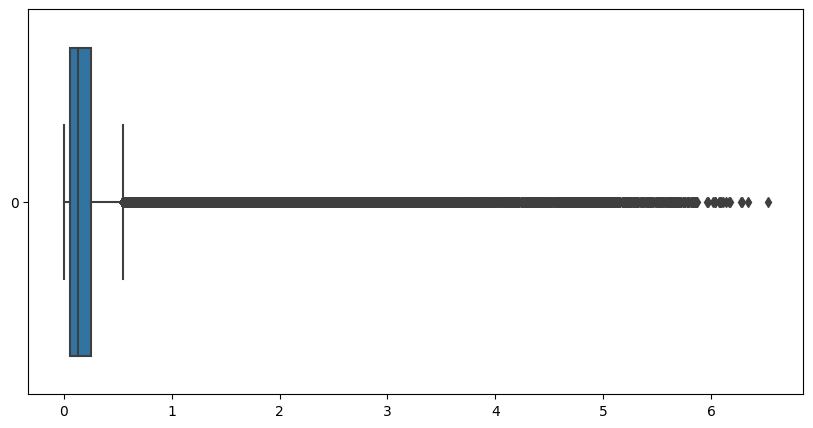

In [30]:
#boxplot to visualize outlier
plt.figure(figsize=(10,5))
sns.boxplot(file_1['KWH_per_hh'],orient='h');


Text(0, 0.5, 'Frequency')

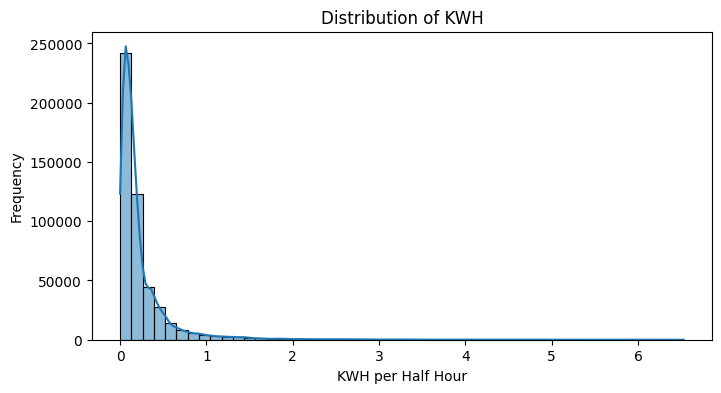

In [31]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(file_1['KWH_per_hh'], bins=50, kde=True)
plt.title('Distribution of KWH')
plt.xlabel('KWH per Half Hour')
plt.ylabel('Frequency')

#### Explore the number of rows in each range 

In [32]:
# Define ranges 
ranges = [(0, 0.5), (0.5, 5.5), (5.5, max(file_1['KWH_per_hh']))]

# Count values for each range
counts = {}
for min_value, max_value in ranges:
    count = file_1[(file_1['KWH_per_hh'] >= min_value) & (file_1['KWH_per_hh'] < max_value)].shape[0]
    counts[f"{min_value} to {max_value}"] = count

# results
for range_label, count in counts.items():
    print(f"Number of values in the range {range_label}: {count}")

Number of values in the range 0 to 0.5: 432556
Number of values in the range 0.5 to 5.5: 51413
Number of values in the range 5.5 to 6.5279999: 86


## Explore Second File

In [33]:
file_2

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000036,"00:00:00 13,01,01",0.006,E,A
1,MAC000036,"00:30:00 13,01,01",0.017,E,A
2,MAC000036,"01:00:00 13,01,01",0.059,E,A
3,MAC000036,"01:30:00 13,01,01",0.000,E,A
4,MAC000036,"02:00:00 13,01,01",0.000,E,A
...,...,...,...,...,...
444893,MAC000069,"20:00:00 13,12,05",0.061,G,C
444894,MAC000069,"20:30:00 13,12,05",0.090,G,C
444895,MAC000069,"21:00:00 13,12,05",0.069,G,C
444896,MAC000069,"21:30:00 13,12,05",0.084,G,C


In [34]:
file_2.isnull().sum() #check missing values

cell_id                    0
DateTime                   0
KWH/hh (per half hour)     0
site_id                    0
region                     0
dtype: int64

In [35]:
file_2.duplicated().sum() #check duplicates

303

In [36]:
#drop missing values
file_2.drop_duplicates(inplace=True)

In [37]:
#rename columns 
file_2=rename_column_KW(file_2)
file_2

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000036,"00:00:00 13,01,01",0.006,E,A
1,MAC000036,"00:30:00 13,01,01",0.017,E,A
2,MAC000036,"01:00:00 13,01,01",0.059,E,A
3,MAC000036,"01:30:00 13,01,01",0.000,E,A
4,MAC000036,"02:00:00 13,01,01",0.000,E,A
...,...,...,...,...,...
444893,MAC000069,"20:00:00 13,12,05",0.061,G,C
444894,MAC000069,"20:30:00 13,12,05",0.090,G,C
444895,MAC000069,"21:00:00 13,12,05",0.069,G,C
444896,MAC000069,"21:30:00 13,12,05",0.084,G,C


In [38]:
#change datetime column to the right format
file_2=change_date_time(file_2,'DateTime')
file_2

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000036,2013-01-01 00:00:00,0.006,E,A
1,MAC000036,2013-01-01 00:30:00,0.017,E,A
2,MAC000036,2013-01-01 01:00:00,0.059,E,A
3,MAC000036,2013-01-01 01:30:00,0.000,E,A
4,MAC000036,2013-01-01 02:00:00,0.000,E,A
...,...,...,...,...,...
444893,MAC000069,2013-05-12 20:00:00,0.061,G,C
444894,MAC000069,2013-05-12 20:30:00,0.090,G,C
444895,MAC000069,2013-05-12 21:00:00,0.069,G,C
444896,MAC000069,2013-05-12 21:30:00,0.084,G,C


In [39]:
file_2.describe() #There is extreme values here the first file we may consider that the values is rare but here the 7657 is wrong

,KWH_per_hh
count,444595.000000
mean,0.257865
std,11.784092
min,0.000000
25%,0.067000
50%,0.145000
75%,0.265000
max,7657.000000


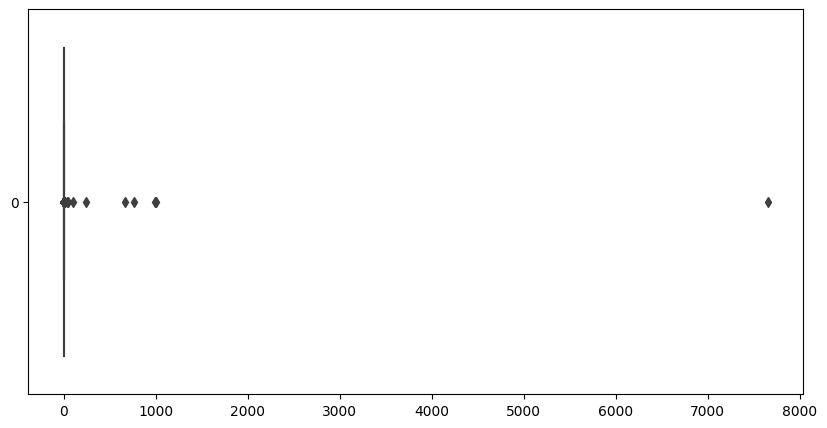

In [40]:
#boxplot to visualize outlier
plt.figure(figsize=(10,5))
sns.boxplot(file_2['KWH_per_hh'],orient='h');


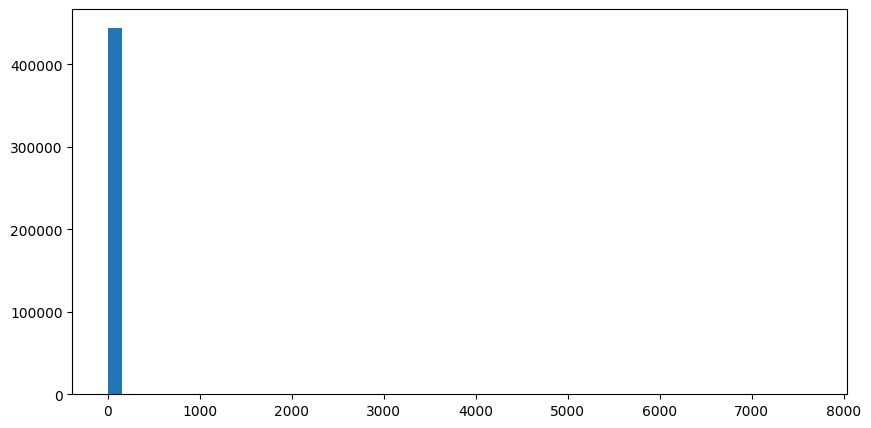

In [41]:
# peform histogram to see the spread of the data
plt.figure(figsize=(10,5))
plt.hist(file_2['KWH_per_hh'],bins=50);


In [42]:

# Define ranges as a list of tuples
ranges = [(0, 0.2), (1, 4), (4, max(file_2['KWH_per_hh']))]

# Count values for each range
counts = {}
for min_value, max_value in ranges:
    count = file_2[(file_2['KWH_per_hh'] >= min_value) & (file_2['KWH_per_hh'] < max_value)].shape[0]
    counts[f"{min_value} to {max_value}"] = count

# Display results
for range_label, count in counts.items():
    print(f"Number of values in the range {range_label}: {count}")

Number of values in the range 0 to 0.2: 283657
Number of values in the range 1 to 4: 13301
Number of values in the range 4 to 7657.0: 64


#### we may impute this value to not effect other calculate in the final datset when concat them

In [43]:
file_2[file_2['KWH_per_hh']>10]

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
853,MAC000036,2013-01-18 18:30:00,7657.0,E,A
1459,MAC000036,2013-01-31 09:00:00,987.0,E,A
1585,MAC000036,2013-02-03 00:00:00,45.0,E,A
188753,MAC000049,2013-10-08 12:00:00,667.0,E,A
188779,MAC000049,2013-10-09 01:00:00,34.0,E,A
188804,MAC000049,2013-10-09 13:30:00,98.0,E,A
444410,MAC000069,2013-05-02 18:30:00,999.0,G,C
444533,MAC000069,2013-05-05 08:00:00,765.0,G,C
444540,MAC000069,2013-05-05 11:30:00,243.0,G,C


#### Impute any value above 10

In [44]:
file_2['KWH_per_hh']=np.where(file_2['KWH_per_hh']>10,np.median(file_2['KWH_per_hh']),file_2['KWH_per_hh'])

In [45]:

# Define ranges as a list of tuples
ranges = [(0, 0.2), (1, 4), (10, max(file_2['KWH_per_hh']))]

# Count values for each range
counts = {}
for min_value, max_value in ranges:
    count = file_2[(file_2['KWH_per_hh'] >= min_value) & (file_2['KWH_per_hh'] < max_value)].shape[0]
    counts[f"{min_value} to {max_value}"] = count

# Display results
for range_label, count in counts.items():
    print(f"Number of values in the range {range_label}: {count}")

Number of values in the range 0 to 0.2: 283666
Number of values in the range 1 to 4: 13301
Number of values in the range 10 to 6.171: 0


In [46]:
df_clean.append(file_2) #add the second file to the list

## Explore third file

In [47]:
file_3

,cell_id,DateTime,KWH/hh (per half hour),site_id,region
0,MAC000069,"22:30:00 13,12,05",0.063,G,C
1,MAC000069,"23:00:00 13,12,05",0.106,G,C
2,MAC000069,"23:30:00 13,12,05",0.029,G,C
3,MAC000069,"00:00:00 13,13,05",0.108,G,C
4,MAC000069,"00:30:00 13,13,05",0.033,G,C
...,...,...,...,...,...
450962,MAC000100,"18:30:00 13,20,12",0.260,N,B
450963,MAC000100,"19:00:00 13,20,12",0.267,N,B
450964,MAC000100,"19:30:00 13,20,12",0.274,N,B
450965,MAC000100,"20:00:00 13,20,12",0.312,N,B


In [48]:
file_3.isnull().sum() #check missing values

cell_id                    0
DateTime                   0
KWH/hh (per half hour)     0
site_id                    0
region                     0
dtype: int64

In [49]:
file_3.duplicated().sum() #check duplicate

308

In [50]:
file_3.drop_duplicates(inplace=True)

In [51]:
file_3=rename_column_KW(file_3) #rename columns
file_3

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000069,"22:30:00 13,12,05",0.063,G,C
1,MAC000069,"23:00:00 13,12,05",0.106,G,C
2,MAC000069,"23:30:00 13,12,05",0.029,G,C
3,MAC000069,"00:00:00 13,13,05",0.108,G,C
4,MAC000069,"00:30:00 13,13,05",0.033,G,C
...,...,...,...,...,...
450962,MAC000100,"18:30:00 13,20,12",0.260,N,B
450963,MAC000100,"19:00:00 13,20,12",0.267,N,B
450964,MAC000100,"19:30:00 13,20,12",0.274,N,B
450965,MAC000100,"20:00:00 13,20,12",0.312,N,B


In [52]:
#change datetime column to right format
file_3=change_date_time(file_3,'DateTime')
file_3

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000069,2013-05-12 22:30:00,0.063,G,C
1,MAC000069,2013-05-12 23:00:00,0.106,G,C
2,MAC000069,2013-05-12 23:30:00,0.029,G,C
3,MAC000069,2013-05-13 00:00:00,0.108,G,C
4,MAC000069,2013-05-13 00:30:00,0.033,G,C
...,...,...,...,...,...
450962,MAC000100,2013-12-20 18:30:00,0.260,N,B
450963,MAC000100,2013-12-20 19:00:00,0.267,N,B
450964,MAC000100,2013-12-20 19:30:00,0.274,N,B
450965,MAC000100,2013-12-20 20:00:00,0.312,N,B


In [53]:
file_3.describe()

,KWH_per_hh
count,450659.000000
mean,0.231781
std,1.743582
min,0.000000
25%,0.067000
50%,0.134000
75%,0.271000
max,765.000000


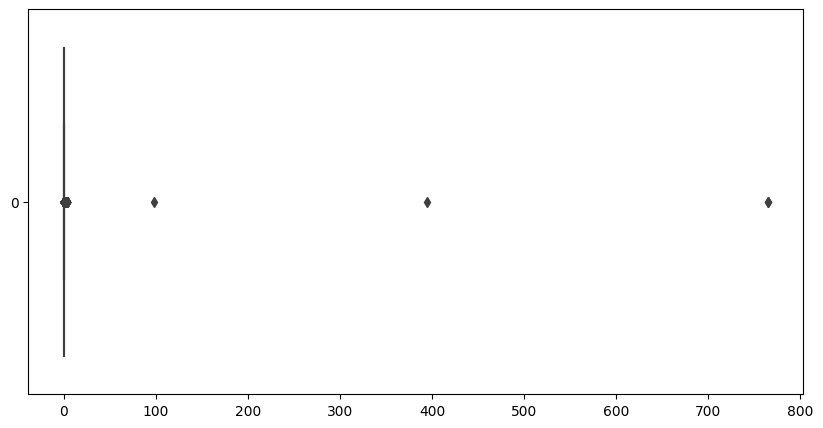

In [54]:
#boxplot to visualize outlier
plt.figure(figsize=(10,5))
sns.boxplot(file_3['KWH_per_hh'],orient='h');


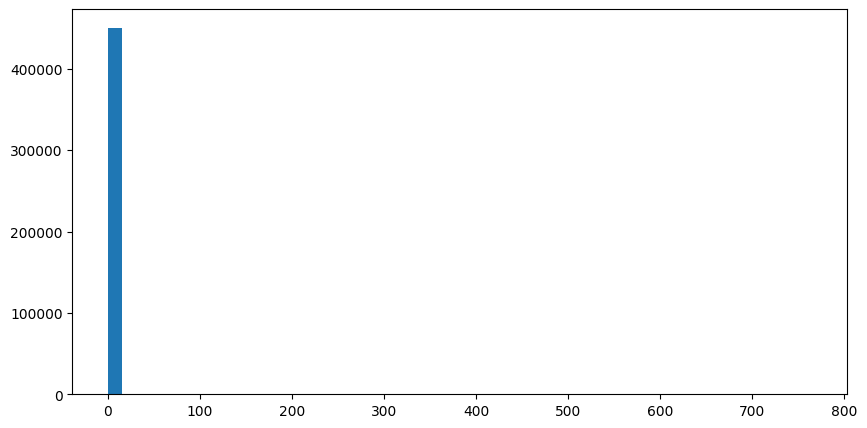

In [55]:
# peform histogram to see the spread of the data
plt.figure(figsize=(10,5))
plt.hist(file_3['KWH_per_hh'],bins=50);

In [56]:
# Define ranges as a list of tuples
ranges = [(0, 0.2), (1, 4), (4, max(file_3['KWH_per_hh']))]

# Count values for each range
counts = {}
for min_value, max_value in ranges:
    count = file_3[(file_3['KWH_per_hh'] >= min_value) & (file_3['KWH_per_hh'] < max_value)].shape[0]
    counts[f"{min_value} to {max_value}"] = count

# Display results
for range_label, count in counts.items():
    print(f"Number of values in the range {range_label}: {count}")

Number of values in the range 0 to 0.2: 290353
Number of values in the range 1 to 4: 12553
Number of values in the range 4 to 765.0: 3


#### Change the values above 10

In [57]:
file_3['KWH_per_hh']=np.where(file_3['KWH_per_hh']>10,np.median(file_3['KWH_per_hh']),file_3['KWH_per_hh'])

In [58]:
file_3['KWH_per_hh'].describe()

count    450659.000000
mean          0.227293
std           0.278226
min           0.000000
25%           0.067000
50%           0.134000
75%           0.271000
max           4.040000
Name: KWH_per_hh, dtype: float64

In [59]:
df_clean.append(file_3) # add third file

## Concat files

In [60]:
#combine all files
df_combined=pd.concat(df_clean,axis=0)
df_combined

,Cell_ID,DateTime,KWH_per_hh,Site_ID,Region
0,MAC000002,2013-01-01 00:00:00,0.219,A,A
1,MAC000002,2013-01-01 00:30:00,0.241,A,A
2,MAC000002,2013-01-01 01:00:00,0.191,A,A
3,MAC000002,2013-01-01 01:30:00,0.235,A,A
4,MAC000002,2013-01-01 02:00:00,0.182,A,A
...,...,...,...,...,...
450962,MAC000100,2013-12-20 18:30:00,0.260,N,B
450963,MAC000100,2013-12-20 19:00:00,0.267,N,B
450964,MAC000100,2013-12-20 19:30:00,0.274,N,B
450965,MAC000100,2013-12-20 20:00:00,0.312,N,B


In [61]:
df_combined.isnull().sum() #check missing values

Cell_ID       0
DateTime      0
KWH_per_hh    0
Site_ID       0
Region        0
dtype: int64

In [62]:
df_combined.duplicated().sum()

0

In [63]:
df_combined.describe()

,KWH_per_hh
count,1.379310e+06
mean,2.325356e-01
std,3.208176e-01
min,0.000000e+00
25%,6.500000e-02
50%,1.360000e-01
75%,2.650000e-01
max,6.528000e+00


In [64]:
df_combined['KWH_per_hh'].median()

0.136

In [65]:
df_combined['Cell_ID'].value_counts().reset_index() # There many missing records in some cell ids as the excepected from all of them is 17520

,index,Cell_ID
0,MAC000002,17520
1,MAC000057,17520
2,MAC000091,17520
3,MAC000027,17520
4,MAC000040,17520
...,...,...
77,MAC000095,13055
78,MAC000063,12767
79,MAC000080,7103
80,MAC000050,5089


Text(0, 0.5, 'Frequency')

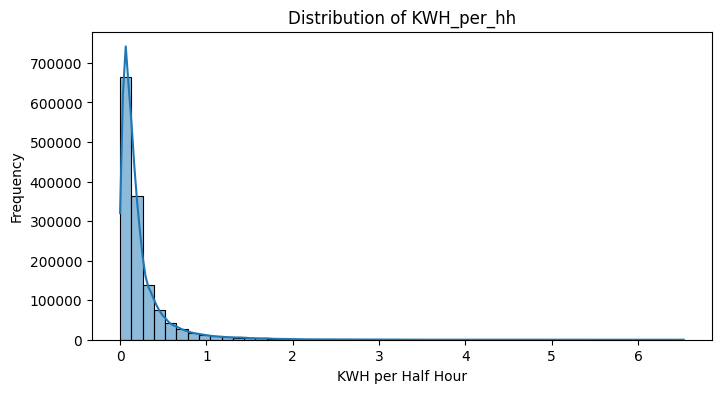

In [66]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(df_combined['KWH_per_hh'], bins=50, kde=True)
plt.title('Distribution of KWH_per_hh')
plt.xlabel('KWH per Half Hour')
plt.ylabel('Frequency')

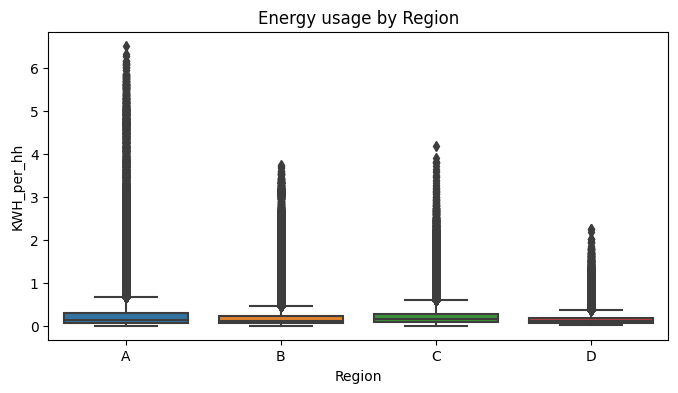

In [67]:
plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_combined, x='Region', y='KWH_per_hh')
plt.title('Energy usage by Region');

In [68]:
print(skew(df_combined['KWH_per_hh']))

4.739263620107742


In [69]:
DataFrame(df_combined['Cell_ID'].value_counts().reset_index()).to_csv('out.csv') # save to csv to explore it more 

In [70]:
df_combined['Cell_ID'].value_counts(ascending=True).reset_index()  # AS shown there cells that doesn`t have at least 70% of it is records those cell will be droppen

,index,Cell_ID
0,MAC000016,721
1,MAC000050,5089
2,MAC000080,7103
3,MAC000063,12767
4,MAC000095,13055
...,...,...
77,MAC000019,17520
78,MAC000018,17520
79,MAC000057,17520
80,MAC000060,17520


In [71]:
#drop those cells where more than 70% of data is missing 
df_combined=df_combined[~df_combined['Cell_ID'].isin(['MAC000016', 'MAC000050', 'MAC000080'])]

In [72]:
#check after drop
df_combined['Cell_ID'].value_counts(ascending=True).reset_index() 

,index,Cell_ID
0,MAC000063,12767
1,MAC000095,13055
2,MAC000028,13392
3,MAC000008,14495
4,MAC000100,16986
...,...,...
74,MAC000010,17520
75,MAC000060,17520
76,MAC000018,17520
77,MAC000091,17520


#### Before imputation the missing in cells we should remove anomlies

In [73]:
# Define ranges as a list of tuples
ranges = [(0, 0.56), (0.56, 1), (1, max(df_combined['KWH_per_hh']))]

# Count values for each range
counts = {}
for min_value, max_value in ranges:
    count = df_combined[(df_combined['KWH_per_hh'] >= min_value) & (df_combined['KWH_per_hh'] < max_value)].shape[0]
    counts[f"{min_value} to {max_value}"] = count

# The results
for range_label, count in counts.items():
    print(f"Number of values in the range {range_label}: {count}")

Number of values in the range 0 to 0.56: 1245918
Number of values in the range 0.56 to 1: 78333
Number of values in the range 1 to 6.5279999: 42145


#### Try different anomly detection to choose best one

In [74]:
#copy the dataframe to not affect original
df_combined_copy=df_combined.copy()

#### MAD

In [75]:
# from pyod.models.mad import MAD

# # Column needs to be checked
# data = df_combined_copy['KWH_per_hh']
# data = data.values.reshape(-1,1)

# # Initiate the Model (choose 3 as it is the common used value in MAD)
# mad_detector = MAD(threshold = 3)

# # fitting the model
# mad_detector.fit(data)

# df_combined_copy['MAD_Library_Label']= mad_detector.labels_

# df_combined_copy['KWH_per_hh_mad']=np.where(df_combined_copy['MAD_Library_Label']==1,np.median(df_combined_copy['KWH_per_hh']),df_combined_copy['KWH_per_hh'])

In [76]:
# df_combined_copy['KWH_per_hh_mad'].describe()

In [77]:
# df_combined_copy['KWH_per_hh_mad'].max()

In [78]:
# print(skew(df_combined_copy['KWH_per_hh_mad']))

In [79]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(10,5))
# plt.hist(df_combined_copy['KWH_per_hh_mad'],bins=50);

In [80]:
# print(skew(df_combined_copy['KWH_per_hh_mad']))

#### IQR

In [81]:
# q1=np.quantile(df_combined_copy['KWH_per_hh'],0.25)
# q3=np.quantile(df_combined_copy['KWH_per_hh'],0.75)
# iqr = q3 - q1
# lower_limit = q1 - 1.5 * iqr
# upper_limit = q3 + 1.5 * iqr
# df_combined_copy['value_check']=np.where(((df_combined_copy['KWH_per_hh'] < lower_limit) | (df_combined_copy['KWH_per_hh'] > upper_limit)),1,0)
# df_combined_copy['value_check'].value_counts()

In [82]:
# df_combined_copy['KWH_per_hh_iqr']=np.where(df_combined_copy['value_check']==1,np.median(df_combined_copy['KWH_per_hh']),df_combined_copy['KWH_per_hh'])

In [83]:
# df_combined_copy['KWH_per_hh_iqr'].describe()

In [84]:
# df_combined_copy['KWH_per_hh_iqr'].max()

In [85]:
# print(skew(df_combined_copy['KWH_per_hh_iqr']))

In [86]:
# # Create the histogram with density curve
# plt.figure(figsize=(10, 6))
# sns.histplot(df_combined_copy['KWH_per_hh_iqr'], kde=True,stat='density')

# # # Add title and labels
# plt.title('Distribution of KWH_per_hh with Density Curve')
# plt.xlabel('KWH_per_hh')
# plt.ylabel('Density')


#### Try the 95th percentile or 99th percentile

In [87]:
# # Define percentiles
# lower_bound = df_combined_copy['KWH_per_hh'].quantile(0.01)
# upper_bound = df_combined_copy['KWH_per_hh'].quantile(0.99)

# # Identify outliers
# df_combined_copy['value_check_99']=np.where(((df_combined_copy['KWH_per_hh'] < lower_bound) | (df_combined_copy['KWH_per_hh'] > upper_bound)),1,0)

# df_combined_copy['value_check_99'].value_counts()

In [88]:
# df_combined_copy['KWH_per_hh_99']=np.where(df_combined_copy['value_check_99']==1,np.median(df_combined_copy['KWH_per_hh']),df_combined_copy['KWH_per_hh'])
# df_combined_copy['KWH_per_hh_99'].describe()

In [89]:
# df_combined_copy['KWH_per_hh_99'].max()

In [90]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(10,5))
# plt.hist(df_combined_copy['KWH_per_hh_99'],bins=50);

In [91]:
# print(skew(df_combined_copy['KWH_per_hh_99']))

In [92]:
# # Define percentiles
# lower_bound = df_combined_copy['KWH_per_hh'].quantile(0.05)
# upper_bound = df_combined_copy['KWH_per_hh'].quantile(0.95)

# # Identify outliers
# df_combined_copy['value_check_95']=np.where(((df_combined_copy['KWH_per_hh'] < lower_bound) | (df_combined_copy['KWH_per_hh'] > upper_bound)),1,0)

# df_combined_copy['value_check_95'].value_counts()

In [93]:
# df_combined_copy['KWH_per_hh_95']=np.where(df_combined_copy['value_check_95']==1,np.median(df_combined_copy['KWH_per_hh']),df_combined_copy['KWH_per_hh'])
# df_combined_copy['KWH_per_hh_95'].describe()

In [94]:
# df_combined_copy['KWH_per_hh_95'].min()

In [95]:
# print(skew(df_combined_copy['KWH_per_hh_95']))

In [96]:
# df_combined['KWH_per_hh_95'].max()

In [97]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(10,5))
# plt.hist(df_combined['KWH_per_hh_95'],bins=50);

In [98]:
# df_combined['KWH_per_hh_95']=np.where(df_combined['value_check_99']==1,np.median(file_1['KWH_per_hh']),df_combined['KWH_per_hh'])


In [99]:
# lower_limit = np.percentile(df_combined['KWH_per_hh'], 1)  # 1st percentile
# upper_limit = np.percentile(df_combined['KWH_per_hh'], 99) # 99th percentile
# df_combined['clipped'] = np.clip(df_combined['KWH_per_hh'], lower_limit, upper_limit)

In [100]:
# df_combined['clipped'].describe()

In [101]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(10,5))
# plt.hist(df_combined['clipped'],bins=50);

#### Try knn to detect outlier

In [102]:
# from sklearn.neighbors import NearestNeighbors

# k = 5  # Number of neighbors
# nn = NearestNeighbors(n_neighbors=k)
# X = df_combined_copy[['KWH_per_hh']].values  # Extract column as 2D array
# nn.fit(X)
# distances, _ = nn.kneighbors(X)
# outlier_scores = distances.mean(axis=1)

# # Calculate thresholds for top 5% and bottom 5% of scores
# upper_threshold = np.percentile(outlier_scores, 95)  # Top 5%
# lower_threshold = np.percentile(outlier_scores, 5)   # Bottom 5%

# # Identify top and bottom outliers
# upper_outliers = outlier_scores > upper_threshold
# lower_outliers = outlier_scores < lower_threshold

# # Impute outliers with the median value
# median_value = df_combined_copy['KWH_per_hh'].median()
# df_combined_copy.loc[upper_outliers, 'KWH_per_hh'] = median_value
# df_combined_copy.loc[lower_outliers, 'KWH_per_hh'] = median_value

# # Print summary of changes
# print(f"Number of upper outliers handled: {upper_outliers.sum()}")
# print(f"Number of lower outliers handled: {lower_outliers.sum()}")

In [103]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(10,5))
# plt.hist(df_combined_copy['KWH_per_hh'],bins=50);

In [104]:
# print(skew(df_combined_copy['KWH_per_hh']))

#### After testing different anomaly detection methods, I determined that the Median Absolute Deviation (MAD) method works best for handling skewness. While the 99th percentile provided reasonable results by not removing all values above 1 (which might be valid data points rather than extreme outliers), I have decided to proceed with MAD as it aligns better with the data's overall characteristics and skewness.

#### Additionally, I will explore a different imputation method instead of using the median value for the entire dataset. The median imputation for the entire dataset, when applied to outliers, results in a peak in the data.

In [105]:
from pyod.models.mad import MAD

# Column needs to be checked
data = df_combined_copy['KWH_per_hh']
data = data.values.reshape(-1,1)

# Initiate the Model (choose 3 as it is the common used value in MAD)
mad_detector = MAD(threshold = 3)

# fitting the model
mad_detector.fit(data)

df_combined_copy['MAD_Library_Label']= mad_detector.labels_
df_combined_copy['MAD_Library_Label'].value_counts()


c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


0    1226038
1     140359
Name: MAD_Library_Label, dtype: int64

In [106]:
# empty dictionary
cell_median = {}

# Calculate the median for each cell
for cell in df_combined_copy['Cell_ID'].unique():
    cell_median[cell] = np.median(df_combined_copy[(df_combined_copy['Cell_ID'] == cell) & (df_combined_copy['MAD_Library_Label'] == 0)]['KWH_per_hh'])

cell_median


{'MAC000002': 0.138,
 'MAC000003': 0.137,
 'MAC000004': 0.0,
 'MAC000006': 0.049,
 'MAC000007': 0.107,
 'MAC000008': 0.273,
 'MAC000009': 0.125,
 'MAC000010': 0.261,
 'MAC000011': 0.186,
 'MAC000012': 0.032,
 'MAC000013': 0.091,
 'MAC000018': 0.149,
 'MAC000019': 0.096,
 'MAC000020': 0.073,
 'MAC000021': 0.374,
 'MAC000022': 0.174,
 'MAC000023': 0.121,
 'MAC000024': 0.081,
 'MAC000025': 0.03,
 'MAC000026': 0.157,
 'MAC000027': 0.153,
 'MAC000028': 0.055,
 'MAC000029': 0.055,
 'MAC000030': 0.133,
 'MAC000032': 0.051,
 'MAC000033': 0.133,
 'MAC000034': 0.122,
 'MAC000035': 0.227,
 'MAC000036': 0.043,
 'MAC000037': 0.0,
 'MAC000038': 0.147,
 'MAC000039': 0.107,
 'MAC000040': 0.359,
 'MAC000041': 0.089,
 'MAC000042': 0.135,
 'MAC000043': 0.055,
 'MAC000045': 0.157,
 'MAC000047': 0.091,
 'MAC000049': 0.25,
 'MAC000053': 0.121,
 'MAC000054': 0.173,
 'MAC000055': 0.175,
 'MAC000056': 0.084,
 'MAC000057': 0.139,
 'MAC000058': 0.051,
 'MAC000059': 0.278,
 'MAC000060': 0.128,
 'MAC000061': 0.081

In [107]:
# Define the median_cell function imputation
def median_cell(row:pd.Series)->float:
    '''
    This Functions aims to change the KWH_per_hh with of it`s corresponding median if the label is 1
    Args:
        - df : Pandas Series
    Return:
        - Returns a Float
    '''
    if row['MAD_Library_Label'] == 0:
        return row['KWH_per_hh']  # If MAD_Library_Label is 0, keep the original value
    else:
        cell = row['Cell_ID']
        return cell_median[cell]  # If MAD_Library_Label is not 0, use the median from cell_median


In [108]:
# Apply the median_cell function to create the new column
df_combined_copy['KWH_per_hh_mad'] = df_combined_copy.apply(median_cell, axis=1)

In [109]:
df_combined_copy['KWH_per_hh_mad'].describe()

count    1.366397e+06
mean     1.546078e-01
std      1.152171e-01
min      0.000000e+00
25%      6.400000e-02
50%      1.290000e-01
75%      2.190000e-01
max      5.090000e-01
Name: KWH_per_hh_mad, dtype: float64

Text(0, 0.5, 'Frequency')

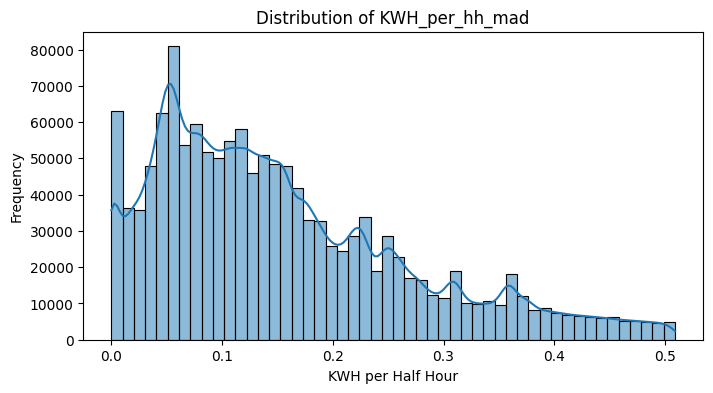

In [110]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(df_combined_copy['KWH_per_hh_mad'], bins=50, kde=True)
plt.title('Distribution of KWH_per_hh_mad')
plt.xlabel('KWH per Half Hour')
plt.ylabel('Frequency')

In [111]:
df_combined_copy['KWH_per_hh_mad'].isnull().sum() #check missing values after imputation

0

In [112]:
print(skew(df_combined_copy['KWH_per_hh_mad']))

0.9399875720549294


In [113]:
#drop original KHW and label
df_combined_copy.drop(columns=['KWH_per_hh','MAD_Library_Label'],inplace=True)

In [115]:
#define the format used
format = '%Y-%m-%d %H:%M:%S'
#get unique cells
cells=list(df_combined_copy['Cell_ID'].unique())
#dict to get the missing records
missing_dates={}
for cell in cells:
    cell_data = df_combined_copy[df_combined_copy['Cell_ID'] == cell]
    missing_dates[cell] = []
    # Generate 17520 half-hour intervals as it is the required number for each cell
    for x in range(17520):
        new_date=datetime.datetime.strptime('2013-01-01 00:00:00',format)+datetime.timedelta(minutes=x*30)
        # Check if the calculated date-time exists in the cell's data
        if not (cell_data['DateTime'] == new_date).any():
            missing_dates[cell].append(new_date)

In [116]:
missing_dates

{'MAC000002': [],
 'MAC000003': [datetime.datetime(2013, 3, 26, 21, 30),
  datetime.datetime(2013, 5, 8, 5, 30)],
 'MAC000004': [datetime.datetime(2013, 5, 4, 6, 0)],
 'MAC000006': [],
 'MAC000007': [datetime.datetime(2013, 2, 16, 12, 30),
  datetime.datetime(2013, 12, 26, 13, 0),
  datetime.datetime(2013, 12, 30, 11, 30)],
 'MAC000008': [datetime.datetime(2013, 10, 2, 15, 30),
  datetime.datetime(2013, 10, 3, 11, 30),
  datetime.datetime(2013, 10, 30, 0, 30),
  datetime.datetime(2013, 10, 30, 1, 0),
  datetime.datetime(2013, 10, 30, 1, 30),
  datetime.datetime(2013, 10, 30, 2, 0),
  datetime.datetime(2013, 10, 30, 2, 30),
  datetime.datetime(2013, 10, 30, 3, 0),
  datetime.datetime(2013, 10, 30, 3, 30),
  datetime.datetime(2013, 10, 30, 4, 0),
  datetime.datetime(2013, 10, 30, 4, 30),
  datetime.datetime(2013, 10, 30, 5, 0),
  datetime.datetime(2013, 10, 30, 5, 30),
  datetime.datetime(2013, 10, 30, 6, 0),
  datetime.datetime(2013, 10, 30, 6, 30),
  datetime.datetime(2013, 10, 30, 7, 

In [117]:
#remove the cells with no missing date
for key,value in list(missing_dates.items()):
    if len(value)==0:
        missing_dates.pop(key)
        

In [118]:
len(missing_dates)

67

In [119]:
missing_dates

{'MAC000003': [datetime.datetime(2013, 3, 26, 21, 30),
  datetime.datetime(2013, 5, 8, 5, 30)],
 'MAC000004': [datetime.datetime(2013, 5, 4, 6, 0)],
 'MAC000007': [datetime.datetime(2013, 2, 16, 12, 30),
  datetime.datetime(2013, 12, 26, 13, 0),
  datetime.datetime(2013, 12, 30, 11, 30)],
 'MAC000008': [datetime.datetime(2013, 10, 2, 15, 30),
  datetime.datetime(2013, 10, 3, 11, 30),
  datetime.datetime(2013, 10, 30, 0, 30),
  datetime.datetime(2013, 10, 30, 1, 0),
  datetime.datetime(2013, 10, 30, 1, 30),
  datetime.datetime(2013, 10, 30, 2, 0),
  datetime.datetime(2013, 10, 30, 2, 30),
  datetime.datetime(2013, 10, 30, 3, 0),
  datetime.datetime(2013, 10, 30, 3, 30),
  datetime.datetime(2013, 10, 30, 4, 0),
  datetime.datetime(2013, 10, 30, 4, 30),
  datetime.datetime(2013, 10, 30, 5, 0),
  datetime.datetime(2013, 10, 30, 5, 30),
  datetime.datetime(2013, 10, 30, 6, 0),
  datetime.datetime(2013, 10, 30, 6, 30),
  datetime.datetime(2013, 10, 30, 7, 0),
  datetime.datetime(2013, 10, 30

In [120]:
# make the dictionary to dataframe to add to original dataframe
df=pd.DataFrame([(key, date) for key, dates in missing_dates.items() for date in dates], columns=['Cell_ID', 'DateTime'])
len(df)

17683

In [121]:
df_final=pd.concat([df,df_combined_copy],axis=0)
df_final

,Cell_ID,DateTime,Site_ID,Region,KWH_per_hh_mad
0,MAC000003,2013-03-26 21:30:00,NaN,NaN,NaN
1,MAC000003,2013-05-08 05:30:00,NaN,NaN,NaN
2,MAC000004,2013-05-04 06:00:00,NaN,NaN,NaN
3,MAC000007,2013-02-16 12:30:00,NaN,NaN,NaN
4,MAC000007,2013-12-26 13:00:00,NaN,NaN,NaN
...,...,...,...,...,...
450962,MAC000100,2013-12-20 18:30:00,N,B,0.260
450963,MAC000100,2013-12-20 19:00:00,N,B,0.267
450964,MAC000100,2013-12-20 19:30:00,N,B,0.274
450965,MAC000100,2013-12-20 20:00:00,N,B,0.312


In [122]:
df_final.isnull().sum() #check that missing values added

Cell_ID               0
DateTime              0
Site_ID           17683
Region            17683
KWH_per_hh_mad    17683
dtype: int64

#### We have two approaches to handle missing values: filling them using the median of the same cell or by using the median of the same date. I have decided to use the median from the same date to capture seasonal changes, especially if more than three values are missing in those cells. For cells with fewer than three missing values, I will fill the gaps using the last available record in the KWH column.

In [123]:
# get the median for each DateTime
date_median = df_combined_copy.groupby('DateTime')['KWH_per_hh_mad'].median()
date_median

DateTime
2013-01-01 00:00:00    0.1490
2013-01-01 00:30:00    0.1350
2013-01-01 01:00:00    0.1370
2013-01-01 01:30:00    0.1350
2013-01-01 02:00:00    0.1210
                        ...  
2013-12-31 21:30:00    0.1545
2013-12-31 22:00:00    0.1660
2013-12-31 22:30:00    0.1545
2013-12-31 23:00:00    0.1670
2013-12-31 23:30:00    0.1690
Name: KWH_per_hh_mad, Length: 17520, dtype: float64

In [124]:
def fill_kwh(group: pd.DataFrame) -> pd.DataFrame:
    """
    This function fills missing `KWH_per_hh_mad` values in the group.

    - If the number of missing values is less than or equal to 3, it uses forward fill.
    - If forward fill does not work, it uses the date-based median to fill the remaining missing values.

    Args:
      - group (pd.DataFrame): A group of data for cell.

    Returns:
      - pd.DataFrame: The updated group with missing `KWH_per_hh_mad` values filled.
    """
    # Forward fill
    if group['KWH_per_hh_mad'].isnull().sum() <= 3:
        group['KWH_per_hh_mad'] = group['KWH_per_hh_mad'].fillna(method='ffill')
    
    # Use date_median to fill
    missing_dates = group[group['KWH_per_hh_mad'].isnull()]['DateTime']
    if not missing_dates.empty:
        group['KWH_per_hh_mad'] = group['KWH_per_hh_mad'].fillna(group['DateTime'].map(date_median))
    
    return group


In [125]:
# Apply to each group
df_final = df_final.groupby('Cell_ID', group_keys=False).apply(fill_kwh)

In [126]:
df_final.isnull().sum()

Cell_ID               0
DateTime              0
Site_ID           17683
Region            17683
KWH_per_hh_mad        0
dtype: int64

Text(0, 0.5, 'Frequency')

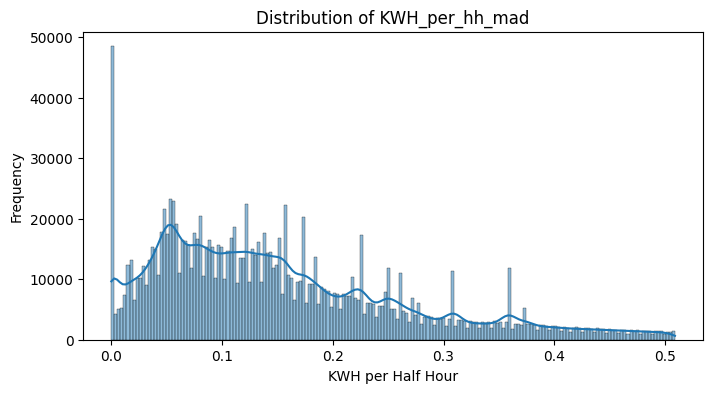

In [127]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8, 4))
sns.histplot(df_final['KWH_per_hh_mad'], kde=True)
plt.title('Distribution of KWH_per_hh_mad')
plt.xlabel('KWH per Half Hour')
plt.ylabel('Frequency')

In [128]:
print(skew(df_final['KWH_per_hh_mad']))

0.9493290808843363


#### After all cleaning steps the skewness decreased from 4.739263620107742 to 0.9493290808843363


In [129]:
#make a dictionary to impute the site with missing rows
pairs = df_final[['Cell_ID', 'Site_ID']].dropna().drop_duplicates().set_index('Cell_ID')['Site_ID'].to_dict()
pairs

{'MAC000002': 'A',
 'MAC000036': 'E',
 'MAC000069': 'G',
 'MAC000070': 'H',
 'MAC000037': 'E',
 'MAC000003': 'P',
 'MAC000072': 'E',
 'MAC000004': 'E',
 'MAC000038': 'L',
 'MAC000073': 'D',
 'MAC000039': 'F',
 'MAC000006': 'Q',
 'MAC000074': 'H',
 'MAC000040': 'A',
 'MAC000007': 'H',
 'MAC000077': 'Q',
 'MAC000041': 'Q',
 'MAC000008': 'H',
 'MAC000078': 'E',
 'MAC000009': 'L',
 'MAC000042': 'Q',
 'MAC000079': 'D',
 'MAC000010': 'H',
 'MAC000043': 'H',
 'MAC000011': 'N',
 'MAC000045': 'E',
 'MAC000081': 'K',
 'MAC000012': 'E',
 'MAC000047': 'Q',
 'MAC000083': 'J',
 'MAC000013': 'K',
 'MAC000049': 'E',
 'MAC000084': 'D',
 'MAC000018': 'E',
 'MAC000085': 'D',
 'MAC000053': 'F',
 'MAC000019': 'K',
 'MAC000086': 'E',
 'MAC000054': 'Q',
 'MAC000020': 'J',
 'MAC000087': 'E',
 'MAC000055': 'K',
 'MAC000021': 'E',
 'MAC000089': 'H',
 'MAC000056': 'Q',
 'MAC000022': 'Q',
 'MAC000090': 'Q',
 'MAC000057': 'E',
 'MAC000023': 'U',
 'MAC000091': 'H',
 'MAC000058': 'E',
 'MAC000024': 'E',
 'MAC000092'

In [130]:
len(pairs)

79

In [131]:
#apply the map function
df_final['Site_ID']=df_final.Cell_ID.map(pairs)


In [132]:
#check if the null values has beed filled
df_final.isnull().sum()

Cell_ID               0
DateTime              0
Site_ID               0
Region            17683
KWH_per_hh_mad        0
dtype: int64

In [133]:
#check the number of pairs again to check we didn`t make a new one mean that something went wrong
len(df_final[['Cell_ID', 'Site_ID']].dropna().drop_duplicates().set_index('Cell_ID')['Site_ID'].to_dict())

79

In [134]:
#make dict for region
pairs_region = df_final[['Cell_ID', 'Region']].dropna().drop_duplicates().set_index('Cell_ID')['Region'].to_dict()
pairs_region

{'MAC000002': 'A',
 'MAC000036': 'A',
 'MAC000069': 'C',
 'MAC000070': 'C',
 'MAC000037': 'A',
 'MAC000003': 'B',
 'MAC000072': 'A',
 'MAC000004': 'A',
 'MAC000038': 'B',
 'MAC000073': 'A',
 'MAC000039': 'C',
 'MAC000006': 'B',
 'MAC000074': 'C',
 'MAC000040': 'A',
 'MAC000007': 'C',
 'MAC000077': 'B',
 'MAC000041': 'B',
 'MAC000008': 'C',
 'MAC000078': 'A',
 'MAC000009': 'B',
 'MAC000042': 'B',
 'MAC000079': 'A',
 'MAC000010': 'C',
 'MAC000043': 'C',
 'MAC000011': 'B',
 'MAC000045': 'A',
 'MAC000081': 'B',
 'MAC000012': 'A',
 'MAC000047': 'B',
 'MAC000083': 'C',
 'MAC000013': 'B',
 'MAC000049': 'A',
 'MAC000084': 'A',
 'MAC000018': 'A',
 'MAC000085': 'A',
 'MAC000053': 'C',
 'MAC000019': 'B',
 'MAC000086': 'A',
 'MAC000054': 'B',
 'MAC000020': 'C',
 'MAC000087': 'A',
 'MAC000055': 'B',
 'MAC000021': 'A',
 'MAC000089': 'C',
 'MAC000056': 'B',
 'MAC000022': 'B',
 'MAC000090': 'B',
 'MAC000057': 'A',
 'MAC000023': 'D',
 'MAC000091': 'C',
 'MAC000058': 'A',
 'MAC000024': 'A',
 'MAC000092'

In [135]:
#match between the cell and region to fill missing records
df_final['Region']=df_final.Cell_ID.map(pairs_region)


In [136]:
#check nulls
df_final.isnull().sum()

Cell_ID           0
DateTime          0
Site_ID           0
Region            0
KWH_per_hh_mad    0
dtype: int64

In [137]:
# use the create_columns for feature engineering and create new columns to get more insights from it
df_final=create_columns(df_final,'DateTime')
df_final

,Cell_ID,DateTime,Site_ID,Region,KWH_per_hh_mad,Day,Quarter,Hour,Weekend,Time Category,Month,Date
0,MAC000002,2013-01-01 00:00:00,A,A,0.2190,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01
0,MAC000003,2013-03-26 21:30:00,P,B,0.2035,Tuesday,1,21,Not Weekend,Night,March,2013-03-26
0,MAC000036,2013-01-01 00:00:00,E,A,0.0060,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01
0,MAC000069,2013-05-12 22:30:00,G,C,0.0630,Sunday,2,22,Not Weekend,Night,May,2013-05-12
1,MAC000002,2013-01-01 00:30:00,A,A,0.2410,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
197445,MAC000085,2013-04-01 07:30:00,D,A,0.3390,Monday,2,7,Not Weekend,Morning,April,2013-04-01
446159,MAC000100,2013-09-11 18:30:00,N,B,0.1410,Wednesday,3,18,Not Weekend,Night,September,2013-09-11
447648,MAC000100,2013-10-12 18:30:00,N,B,0.2510,Saturday,4,18,Weekend,Night,October,2013-10-12
449137,MAC000100,2013-11-12 18:30:00,N,B,0.4950,Tuesday,4,18,Not Weekend,Night,November,2013-11-12


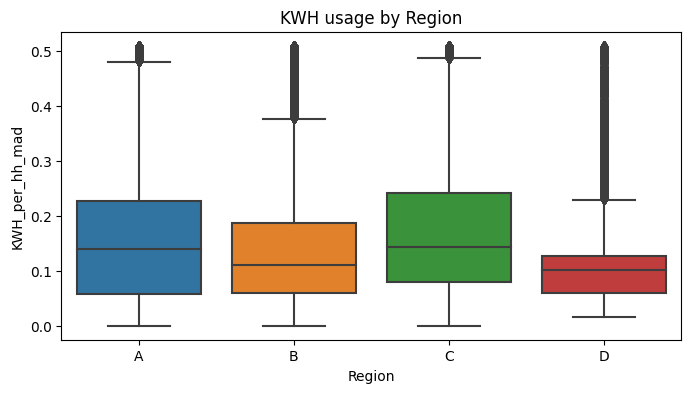

In [138]:
#see box plot after rempve the outliers
plt.subplots(figsize=(8, 4))
sns.boxplot(data=df_final, x='Region', y='KWH_per_hh_mad')
plt.title('KWH usage by Region');

## Merge between demand and final file

In [139]:
engergy_demand=pd.merge(df_final,demand,how='left',left_on='DateTime',right_on='DemandDateTime')
engergy_demand

,Cell_ID,DateTime,Site_ID,Region,KWH_per_hh_mad,Day,Quarter,Hour,Weekend,Time Category,Month,Date,DemandDateTime,Demand
0,MAC000002,2013-01-01 00:00:00,A,A,0.2190,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,2013-01-01 00:00:00,Normal
1,MAC000003,2013-03-26 21:30:00,P,B,0.2035,Tuesday,1,21,Not Weekend,Night,March,2013-03-26,2013-03-26 21:30:00,Normal
2,MAC000036,2013-01-01 00:00:00,E,A,0.0060,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,2013-01-01 00:00:00,Normal
3,MAC000069,2013-05-12 22:30:00,G,C,0.0630,Sunday,2,22,Not Weekend,Night,May,2013-05-12,2013-05-12 22:30:00,Normal
4,MAC000002,2013-01-01 00:30:00,A,A,0.2410,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,2013-01-01 00:30:00,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384075,MAC000085,2013-04-01 07:30:00,D,A,0.3390,Monday,2,7,Not Weekend,Morning,April,2013-04-01,2013-04-01 07:30:00,Normal
1384076,MAC000100,2013-09-11 18:30:00,N,B,0.1410,Wednesday,3,18,Not Weekend,Night,September,2013-09-11,2013-09-11 18:30:00,Normal
1384077,MAC000100,2013-10-12 18:30:00,N,B,0.2510,Saturday,4,18,Weekend,Night,October,2013-10-12,2013-10-12 18:30:00,Normal
1384078,MAC000100,2013-11-12 18:30:00,N,B,0.4950,Tuesday,4,18,Not Weekend,Night,November,2013-11-12,2013-11-12 18:30:00,Normal


In [140]:
engergy_demand.isnull().sum()

Cell_ID           0
DateTime          0
Site_ID           0
Region            0
KWH_per_hh_mad    0
Day               0
Quarter           0
Hour              0
Weekend           0
Time Category     0
Month             0
Date              0
DemandDateTime    0
Demand            0
dtype: int64

In [141]:
engergy_demand.drop(columns=['DemandDateTime'],inplace=True)

In [142]:
#create cost column from demand price
engergy_demand=demand_price(engergy_demand)
engergy_demand

,Cell_ID,DateTime,Site_ID,Region,KWH_per_hh_mad,Day,Quarter,Hour,Weekend,Time Category,Month,Date,Demand,Price,Cost
0,MAC000002,2013-01-01 00:00:00,A,A,0.2190,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,Normal,19.46,4.26174
1,MAC000003,2013-03-26 21:30:00,P,B,0.2035,Tuesday,1,21,Not Weekend,Night,March,2013-03-26,Normal,19.46,3.96011
2,MAC000036,2013-01-01 00:00:00,E,A,0.0060,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,Normal,19.46,0.11676
3,MAC000069,2013-05-12 22:30:00,G,C,0.0630,Sunday,2,22,Not Weekend,Night,May,2013-05-12,Normal,19.46,1.22598
4,MAC000002,2013-01-01 00:30:00,A,A,0.2410,Tuesday,1,0,Not Weekend,Morning,January,2013-01-01,Normal,19.46,4.68986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384075,MAC000085,2013-04-01 07:30:00,D,A,0.3390,Monday,2,7,Not Weekend,Morning,April,2013-04-01,Normal,19.46,6.59694
1384076,MAC000100,2013-09-11 18:30:00,N,B,0.1410,Wednesday,3,18,Not Weekend,Night,September,2013-09-11,Normal,19.46,2.74386
1384077,MAC000100,2013-10-12 18:30:00,N,B,0.2510,Saturday,4,18,Weekend,Night,October,2013-10-12,Normal,19.46,4.88446
1384078,MAC000100,2013-11-12 18:30:00,N,B,0.4950,Tuesday,4,18,Not Weekend,Night,November,2013-11-12,Normal,19.46,9.63270


In [143]:
#save final file
engergy_demand.to_csv('engergy_demand.csv')

#### After we ensure the data is represenatative and cleaning we may do some visualiztion to discover more about the data and relation between columns

## Data Visualization

#### Note there is not different after cleaning if we use medain or mean here

In [144]:
median_cons_day_pivot=pd.pivot_table(engergy_demand,index='Day',values='KWH_per_hh_mad',aggfunc='median')
median_cons_day_pivot

,KWH_per_hh_mad
Day,
Friday,0.129
Monday,0.129
Saturday,0.132
Sunday,0.131
Thursday,0.128
Tuesday,0.128
Wednesday,0.128


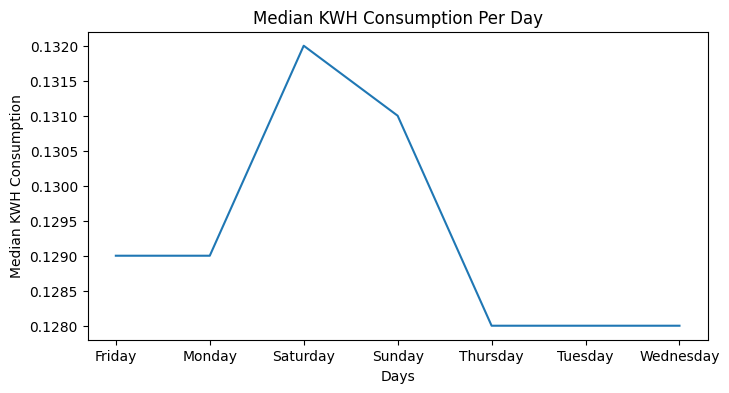

In [145]:
#line chart for kwh and days
plt.figure(figsize=(8,4))
plt.plot(median_cons_day_pivot.index,median_cons_day_pivot['KWH_per_hh_mad'])
plt.ylabel('Median KWH Consumption')
plt.xlabel('Days')
plt.title('Median KWH Consumption Per Day');

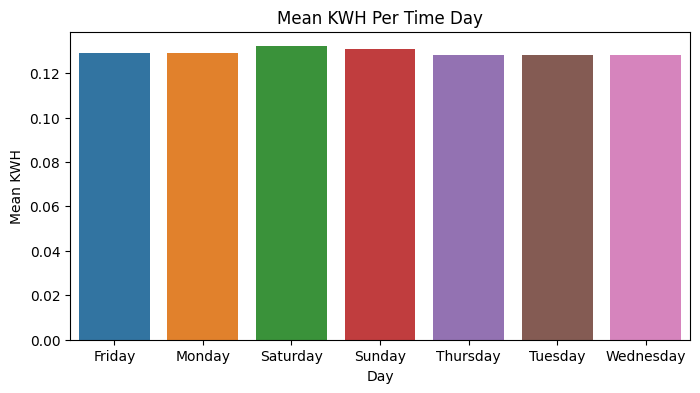

In [146]:
#bar chart
plt.figure(figsize=(8,4))
sns.barplot(x=median_cons_day_pivot.index,y=median_cons_day_pivot['KWH_per_hh_mad'])
plt.ylabel('Mean KWH')
plt.title('Mean KWH Per Time Day');

#### Saturday has the highest numbers, while Thursday has the lowest, with only small differences between them

In [147]:
medianKWH_per_hour = engergy_demand.pivot_table(index='Hour',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_per_hour

,KWH_per_hh_mad
Hour,
0,0.1050
1,0.0920
2,0.0840
3,0.0820
4,0.0820
5,0.0880
6,0.1050
7,0.1245
8,0.1380


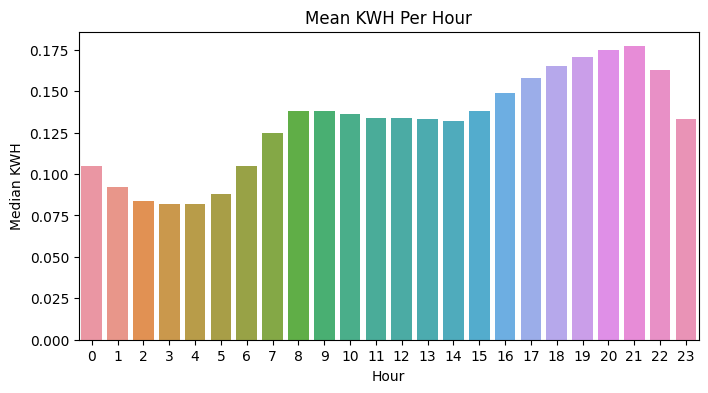

In [148]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_per_hour.index,y=medianKWH_per_hour['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Mean KWH Per Hour');

In [149]:
medianKWH_time=engergy_demand.pivot_table(index='Time Category',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_time

,KWH_per_hh_mad
Time Category,
Afternoon,0.141
Morning,0.107
Night,0.164


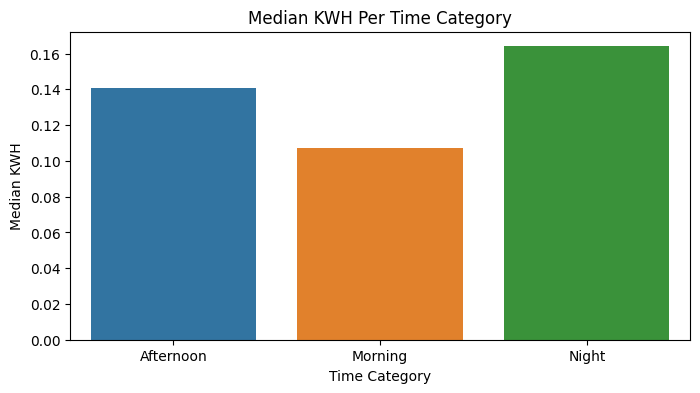

In [150]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_time.index,y=medianKWH_time['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Time Category');

#### Hourly data shows low consumption after midnight, which is expected, followed by a gradual increase as the day progresses

In [151]:
medianKWH_demand=engergy_demand.pivot_table(index='Demand',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_demand

,KWH_per_hh_mad
Demand,
High,0.147
Low,0.127
Normal,0.128


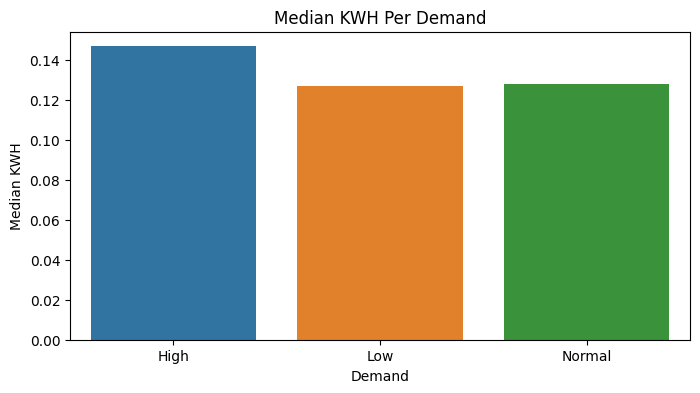

In [152]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_demand.index,y=medianKWH_demand['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Demand');

In [153]:
engergy_demand_grouped = engergy_demand.groupby('Demand').size()
engergy_demand_grouped

Demand
High        62252
Low        131140
Normal    1190688
dtype: int64

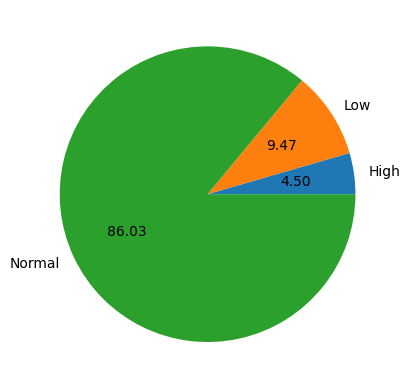

In [154]:
plt.pie(engergy_demand_grouped,labels=engergy_demand_grouped.index,autopct='%.2f');

#### The highest demand was normal and highest consumption is in high demand

In [155]:
#compare between quarter
Q1 = engergy_demand[engergy_demand["Quarter"]==1]
Q2 = engergy_demand[engergy_demand["Quarter"]==2]
Q3 = engergy_demand[engergy_demand["Quarter"]==3]
Q4 = engergy_demand[engergy_demand["Quarter"]==4]

In [156]:
print(f"first quarter: {skew(Q1['KWH_per_hh_mad'])}")
print(f"second quarter: {skew(Q2['KWH_per_hh_mad'])}")
print(f"third quarter: {skew(Q3['KWH_per_hh_mad'])}")
print(f"fourth quarter: {skew(Q4['KWH_per_hh_mad'])}")

first quarter: 0.8571921566345824
second quarter: 0.9915029306963982
third quarter: 1.0136562362430894
fourth quarter: 0.9208324985263382


<Axes: xlabel='KWH_per_hh_mad', ylabel='Count'>

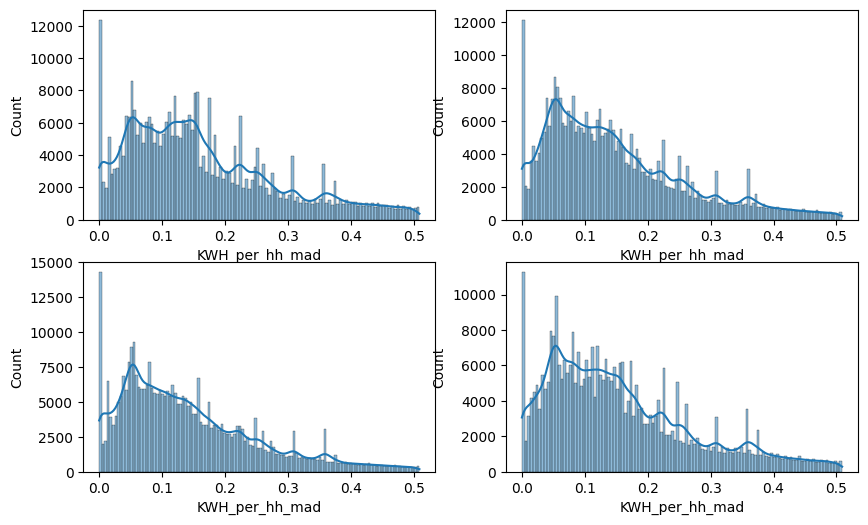

In [157]:
fig,ax= plt.subplots(2,2,figsize=(10,6))
sns.histplot(Q1['KWH_per_hh_mad'], kde=True, ax=ax[0, 0]) 
sns.histplot(Q2['KWH_per_hh_mad'], kde=True, ax=ax[0, 1])
sns.histplot(Q3['KWH_per_hh_mad'], kde=True, ax=ax[1, 0]) 
sns.histplot(Q4['KWH_per_hh_mad'], kde=True, ax=ax[1, 1])  

In [158]:
medianKWH_quarter=engergy_demand.pivot_table(index='Quarter',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_quarter

,KWH_per_hh_mad
Quarter,
1,0.141
2,0.124
3,0.119
4,0.133


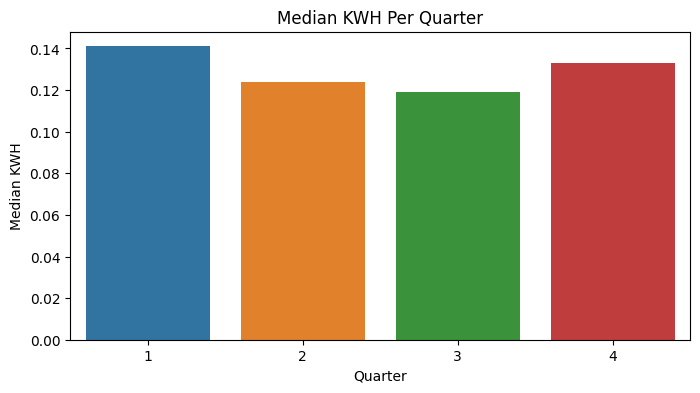

In [159]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_quarter.index,y=medianKWH_quarter['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Quarter');

#### There no major difference in the distribution between quarter the only difference is the first quarter is less one in skewness

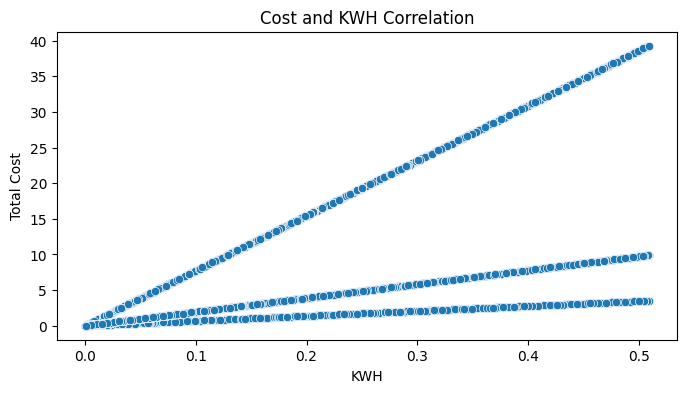

In [160]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=engergy_demand, 
    x='KWH_per_hh_mad', 
    y='Cost', 
)

plt.title('Cost and KWH Correlation')
plt.ylabel('Total Cost')
plt.xlabel('KWH');



In [161]:
engergy_demand['KWH_per_hh_mad'].corr(engergy_demand['Cost'])

0.686627998690939

#### The correlation is  moderate to strong positive relationship meaning as one KWH increases, the Cost increase and this expected

In [162]:
medianKWH_site=engergy_demand.pivot_table(index='Site_ID',values='KWH_per_hh_mad',aggfunc='mean')
medianKWH_site

,KWH_per_hh_mad
Site_ID,
A,0.231503
C,0.317785
D,0.173820
E,0.135793
F,0.157395
G,0.172935
H,0.178869
J,0.155434
K,0.152974


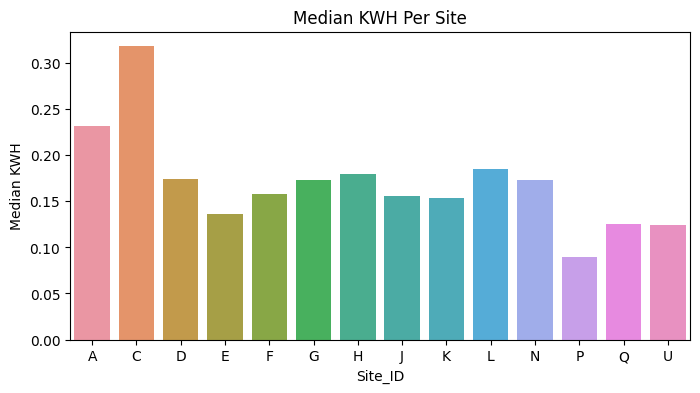

In [163]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_site.index,y=medianKWH_site['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Site');

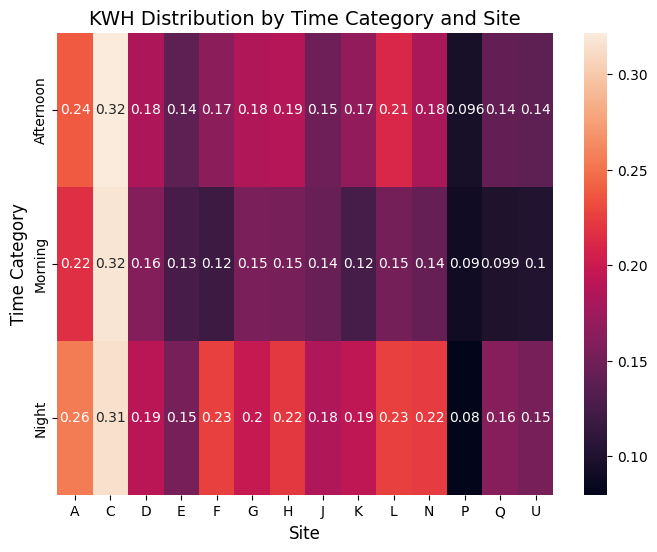

In [164]:
pivot_table = engergy_demand.pivot_table(
    index='Time Category', 
    columns='Site_ID', 
    values='KWH_per_hh_mad', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True)

plt.title('KWH Distribution by Time Category and Site', fontsize=14)
plt.xlabel('Site', fontsize=12)
plt.ylabel('Time Category', fontsize=12)
plt.show()


#### There is a difference in energy consumption across sites, with Site C having the highest consumption and Site P the lowest

In [165]:
medianKWH_region=engergy_demand.pivot_table(index='Region',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_region

,KWH_per_hh_mad
Region,
A,0.139
B,0.111
C,0.144
D,0.101


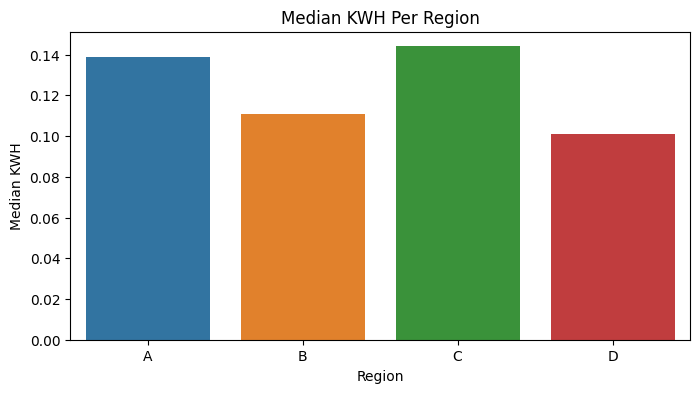

In [166]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_region.index,y=medianKWH_region['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Region');

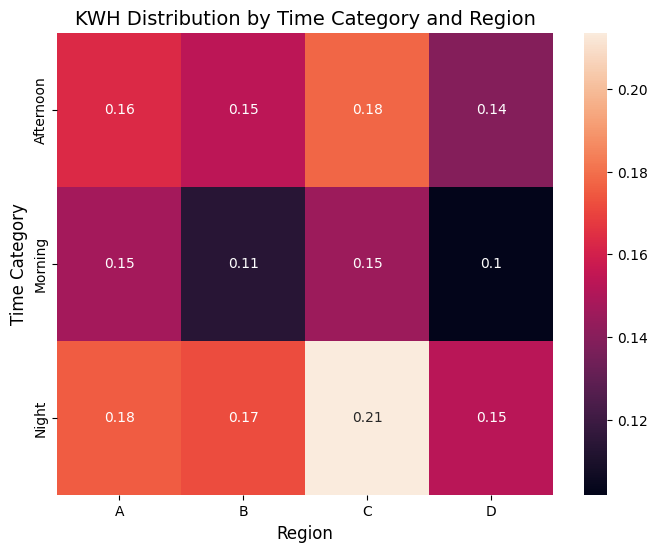

In [167]:
pivot_table = engergy_demand.pivot_table(
    index='Time Category', 
    columns='Region', 
    values='KWH_per_hh_mad', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True)

plt.title('KWH Distribution by Time Category and Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Time Category', fontsize=12)
plt.show()


#### There is a difference in energy consumption across regions, with region C having the highest consumption and region D the lowest


In [168]:
medianKWH_weekend=engergy_demand.pivot_table(index='Weekend',values='KWH_per_hh_mad',aggfunc='median')
medianKWH_weekend

,KWH_per_hh_mad
Weekend,
Not Weekend,0.129
Weekend,0.130


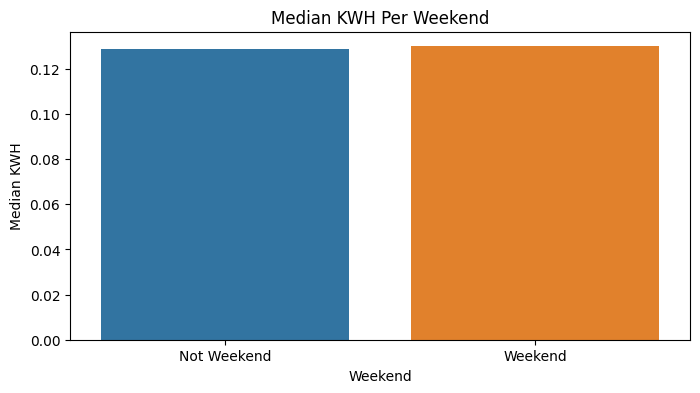

In [169]:
plt.figure(figsize=(8,4))
sns.barplot(x=medianKWH_weekend.index,y=medianKWH_weekend['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Weekend');

#### There is almost between the weekend and not

In [170]:
demand_KWH_total=engergy_demand.pivot_table(index='Demand',values='KWH_per_hh_mad',aggfunc='median')
demand_KWH_total

,KWH_per_hh_mad
Demand,
High,0.147
Low,0.127
Normal,0.128


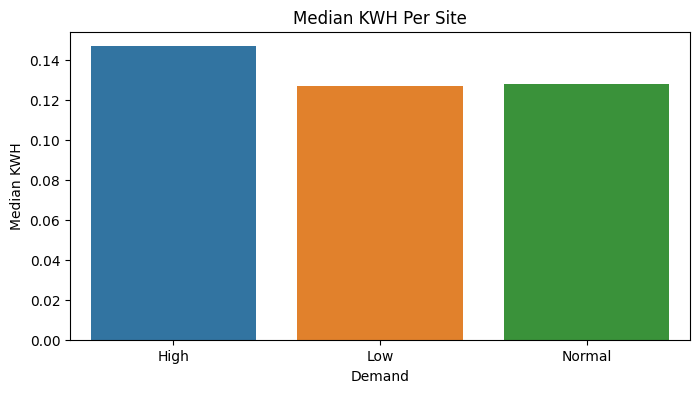

In [171]:
plt.figure(figsize=(8,4))
sns.barplot(x=demand_KWH_total.index,y=demand_KWH_total['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Site');

### Cost Visualization

In [172]:
median_cost_per_hour = engergy_demand.pivot_table(index='Hour',values='Cost',aggfunc='median')
median_cost_per_hour

,Cost
Hour,
0,1.86816
1,1.65410
2,1.52761
3,1.47896
4,1.47896
5,1.59572
6,1.88774
7,2.25736
8,2.51034


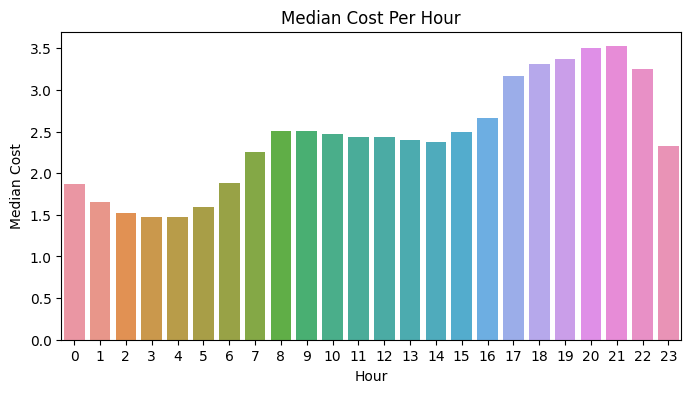

In [173]:
plt.figure(figsize=(8,4))
sns.barplot(x=median_cost_per_hour.index,y=median_cost_per_hour['Cost'])
plt.ylabel('Median Cost')
plt.title('Median Cost Per Hour');

In [174]:
region_cost=engergy_demand.pivot_table(index='Region',values='Cost',aggfunc='median')
region_cost

,Cost
Region,
A,2.57686
B,2.08222
C,2.60764
D,1.86816


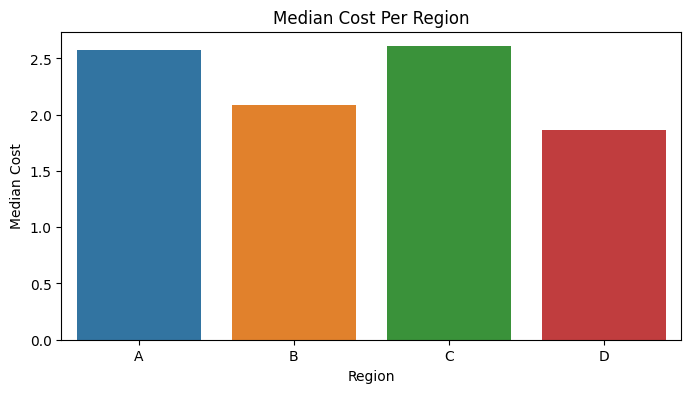

In [175]:
plt.figure(figsize=(8,4))
sns.barplot(x=region_cost.index,y=region_cost['Cost'])
plt.ylabel('Median Cost')
plt.title('Median Cost Per Region');

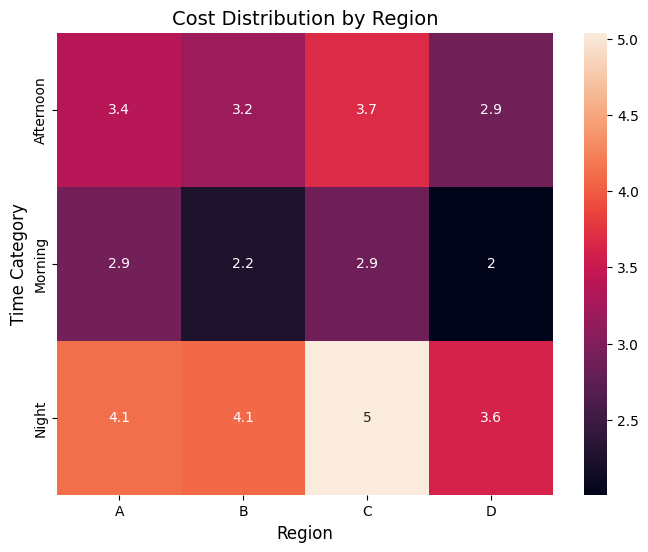

In [176]:
pivot_table = engergy_demand.pivot_table(
    index='Time Category', 
    columns='Region', 
    values='Cost', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True)

plt.title('Cost Distribution by Region', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Time Category', fontsize=12)
plt.show()


#### There is a difference in costs across regions, with Region C paying the most and Region D the least


In [177]:
site_cost=engergy_demand.pivot_table(index='Site_ID',values='Cost',aggfunc='median')
site_cost

,Cost
Site_ID,
A,3.46388
C,6.01314
D,3.05522
E,1.96546
F,2.35466
G,2.74386
H,2.86062
J,2.47142
K,2.39358


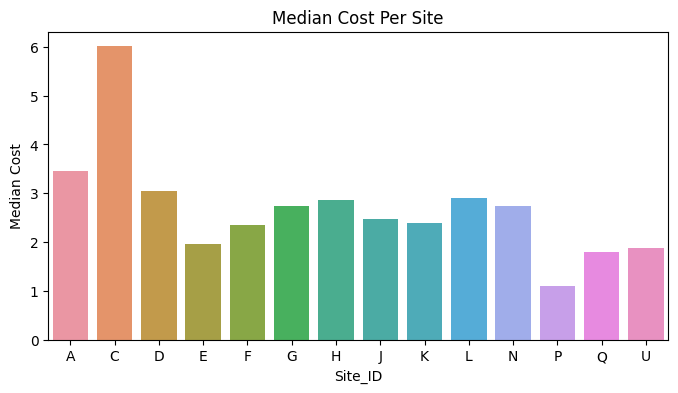

In [178]:
plt.figure(figsize=(8,4))
sns.barplot(x=site_cost.index,y=site_cost['Cost'])
plt.ylabel('Median Cost')
plt.title('Median Cost Per Site');

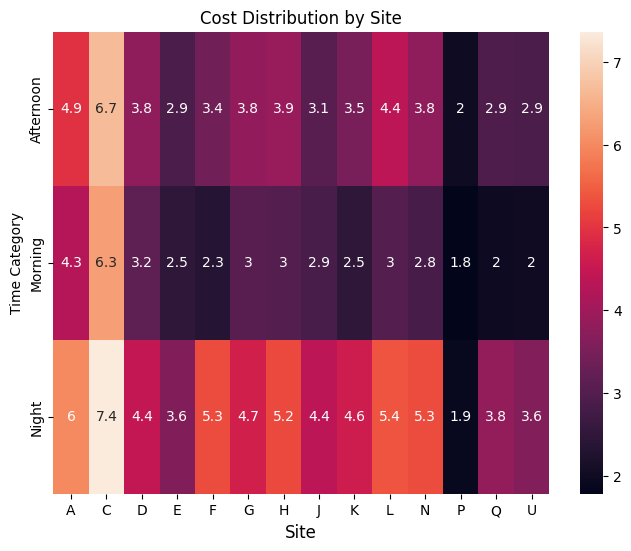

In [179]:
pivot_table = engergy_demand.pivot_table(
    index='Time Category', 
    columns='Site_ID', 
    values='Cost', 
    aggfunc='mean'
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True)

plt.title('Cost Distribution by Site')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Time Category');

#### There is a difference in costs across sites, with Site C incurring the highest expenses and Site P the lowest

In [180]:
demand_cost_total=engergy_demand.pivot_table(index='Demand',values='Cost',aggfunc='median')
demand_cost_total

,Cost
Demand,
High,11.34987
Low,0.87503
Normal,2.49088


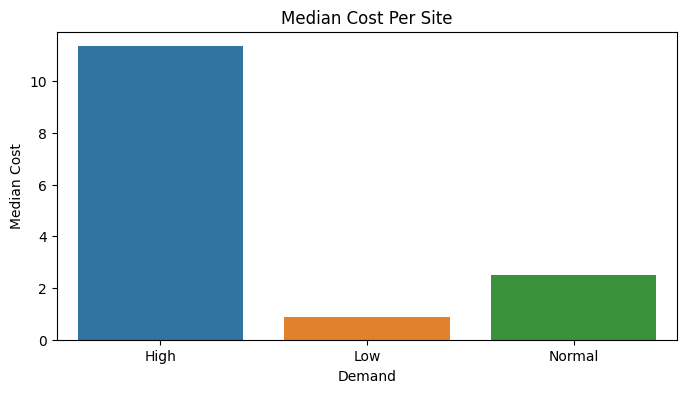

In [181]:
plt.figure(figsize=(8,4))
sns.barplot(x=demand_cost_total.index,y=demand_cost_total['Cost'])
plt.ylabel('Median Cost')
plt.title('Median Cost Per Site');

In [182]:
demand_cost_Region=engergy_demand.pivot_table(index='Demand',columns='Region',values='Cost',aggfunc='median')
demand_cost_Region

Region,A,B,C,D
Demand,,,,
High,11.65871,10.50056,12.81686,8.72473
Low,0.95082,0.75790,0.97149,0.67522
Normal,2.68548,2.16006,2.78278,1.94600


In [183]:
demand_cost_Region=engergy_demand.pivot_table(index='Demand',columns='Site_ID',values='Cost',aggfunc='median')
demand_cost_Region

Site_ID,A,C,D,E,F,G,H,J,K,L,N,P,Q,U
Demand,,,,,,,,,,,,,,
High,17.140620,23.85789,12.50802,9.96009,10.925215,12.35360,14.43827,11.73592,11.11824,16.36852,14.36106,4.55539,9.03357,8.72473
Low,1.353885,2.12901,1.08173,0.81302,0.833690,1.02661,1.08173,0.92326,0.84747,1.07484,0.97149,0.38584,0.65455,0.67522
Normal,3.853080,6.01314,3.07468,2.16006,2.393580,2.84116,3.11360,2.58818,2.49088,3.07468,2.86062,1.10922,1.88762,1.94600


In [184]:
engergy_demand[engergy_demand['Demand']=='High']['Cost'].max(axis=0)

39.29989

In [185]:
engergy_demand[engergy_demand['Demand']=='High']['KWH_per_hh_mad'].max()

0.509

In [186]:
engergy_demand[engergy_demand['Demand']=='Normal']['Cost'].max(axis=0)

9.905140000000001

In [187]:
engergy_demand[engergy_demand['Demand']=='Normal']['KWH_per_hh_mad'].max(axis=0)

0.509

In [188]:
engergy_demand[engergy_demand['Demand']=='Low']['Cost'].max(axis=0)

3.5070099999999997

In [189]:
engergy_demand[engergy_demand['Demand']=='Low']['KWH_per_hh_mad'].max(axis=0)

0.509

In [190]:
low_count_org = len(engergy_demand[(engergy_demand['Demand'] == 'Low') & (engergy_demand['KWH_per_hh_mad'] == 0)])
high_count_org = len(engergy_demand[(engergy_demand['Demand'] == 'High') & (engergy_demand['KWH_per_hh_mad'] == 0)])
normal_count_org = len(engergy_demand[(engergy_demand['Demand'] == 'Normal') & (engergy_demand['KWH_per_hh_mad'] == 0)])

print(f"Low Demand Count: {low_count_org}")
print(f"High Demand Count: {high_count_org}")
print(f"Normal Demand Count: {normal_count_org}")

Low Demand Count: 4446
High Demand Count: 1919
Normal Demand Count: 40289


## Hypothesis Testing

#### ANOVE Test 1
- `H0`: No Difference between Sites in KWH
- `HA`: There is Difference bet. Sites based on KWH

In [191]:
result=pg.anova(data = engergy_demand, dv = 'KWH_per_hh_mad', between = 'Site_ID')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,Site_ID,13,1384066,10174.456553,0.0,0.087229


In [192]:
if result.iloc[:,4].values < 0.05:
    print("Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between the groups defined by Site_ID")
else:
    print("Accept the Null Hypothesis: No significant difference between groups")

Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between the groups defined by Site_ID


Text(0, 0.5, 'KWH per Site')

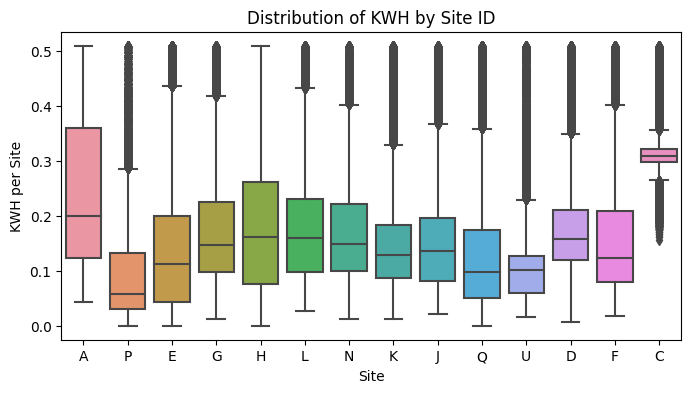

In [193]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Site_ID', y='KWH_per_hh_mad', data=engergy_demand)
plt.title('Distribution of KWH by Site ID')
plt.xlabel('Site')
plt.ylabel('KWH per Site')

#### ANOVE Test 2
- `H0`: No Difference between Regions in KWH
- `HA`: There is Difference between Sites based on KWH

In [194]:
result=pg.anova(data = engergy_demand, dv = 'KWH_per_hh_mad', between = 'Region')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,Region,3,1384076,6456.970242,0.0,0.013802


In [195]:
if result.iloc[:,4].values < 0.05:
    print("Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between the groups defined by Region")
else:
    print("Accept the Null Hypothesis: No significant difference between groups")

Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between the groups defined by Region


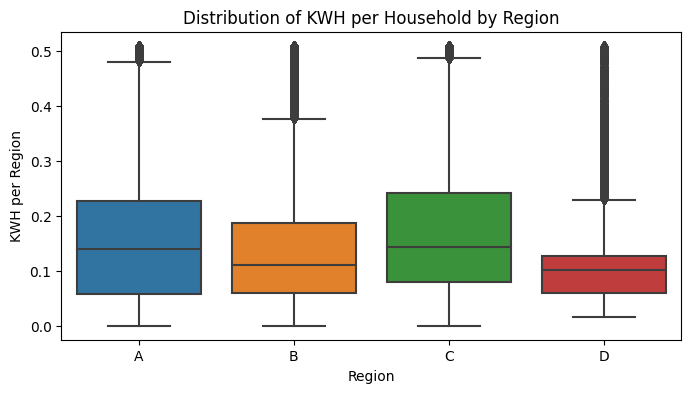

In [196]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Region', y='KWH_per_hh_mad', data=engergy_demand)
plt.title('Distribution of KWH per Household by Region')
plt.xlabel('Region')
plt.ylabel('KWH per Region')
plt.show()

#### ANOVE Test 3
- `H0`: No Difference between KWH in demand
- `HA`: There is Difference between Demand

In [197]:
result=pg.anova(data = engergy_demand, dv = 'KWH_per_hh_mad', between = 'Demand')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,Demand,2,1384077,598.340488,1.804261e-260,0.000864


In [198]:
if result.iloc[:,4].values < 0.05:
    print("Reject the Null Hypothsis")
else:
    print("Accept the Null Hypothesis")

Reject the Null Hypothsis


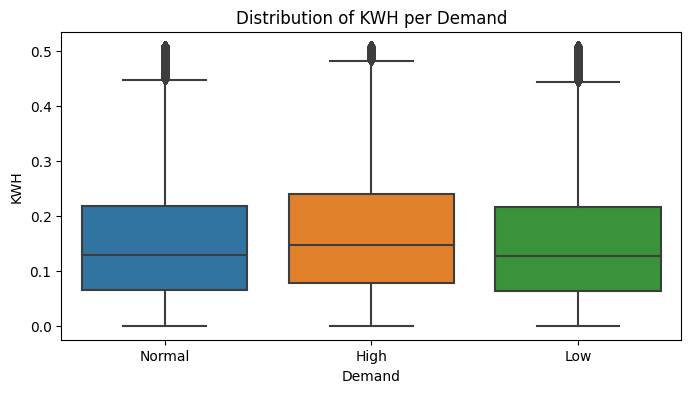

In [199]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Demand', y='KWH_per_hh_mad', data=engergy_demand)
plt.title('Distribution of KWH per Demand')
plt.xlabel('Demand')
plt.ylabel('KWH')
plt.show()

#### ANOVE Test 4
- `H0`: No Difference between Cost in demand
- `HA`: There is Difference between Demand

In [200]:
result=pg.anova(data = engergy_demand, dv = 'Cost', between = 'Demand')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,Demand,2,1384077,418055.93173,0.0,0.376595


In [201]:
if result.iloc[:,4].values < 0.05:
    print("Reject the Null Hypothsis")
else:
    print("Accept the Null Hypothesis")

Reject the Null Hypothsis


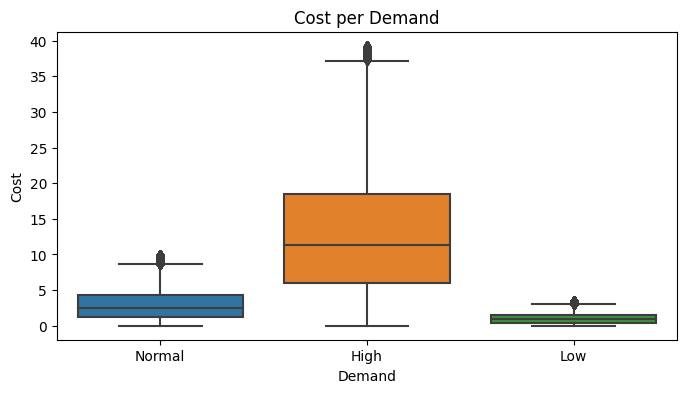

In [202]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Demand', y='Cost', data=engergy_demand)
plt.title('Cost per Demand')
plt.xlabel('Demand')
plt.ylabel('Cost')
plt.show()

#### ANOVE Test 5
- `H0`: No Difference between time of the day in consumption
- `HA`: There is Difference bet. time of the day based in consumption

In [203]:
result=pg.anova(data = engergy_demand, dv = 'KWH_per_hh_mad', between = 'Time Category')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,Time Category,2,1384077,23086.397587,0.0,0.032283


In [204]:
if result.iloc[:,4].values < 0.05:
    print("Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between Time of the day")
else:
    print("Accept the Null Hypothesis: No significant difference between Time of the day")

Reject the Null Hypothsis: There is a difference in KWH_per_hh_mad between Time of the day


Text(0, 0.5, 'KWH')

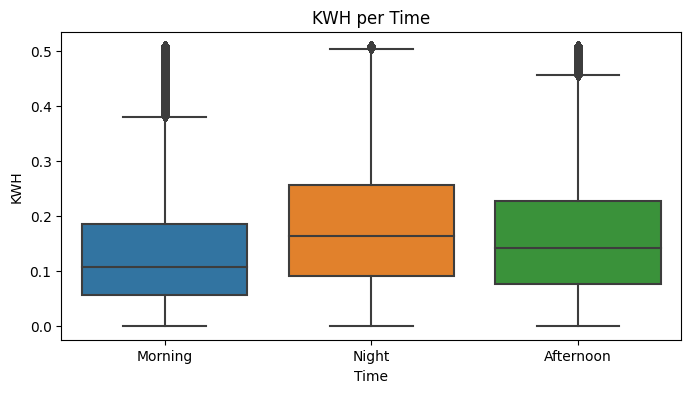

In [205]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Time Category', y='KWH_per_hh_mad', data=engergy_demand)
plt.title('KWH per Time')
plt.xlabel('Time')
plt.ylabel('KWH')

#### Use correlation test if we use time as numerical not categorical 

In [206]:
from scipy.stats import spearmanr, pearsonr

corr, p_value = pearsonr(engergy_demand['Hour'], engergy_demand['KWH_per_hh_mad'])
print(f"pearsonr Correlation: {corr}, p-value: {p_value}")


pearsonr Correlation: 0.20398900919731508, p-value: 0.0


In [207]:
corr, p_value = spearmanr(engergy_demand['Hour'], engergy_demand['KWH_per_hh_mad'])
print(f"Spearman Correlation: {corr}, p-value: {p_value}")

Spearman Correlation: 0.21850323421626033, p-value: 0.0


#### Reject the Null Hypothesis in the two tests

### Test 6
- `H0`: No Change in Proportions between Time
- `HA`: There is significat Change

In [208]:
# Contingency Table
contingency_table = pd.crosstab(engergy_demand['Time Category'], engergy_demand['Demand'])
# print(chi2_contingency(contingency_table))
# Perform Chi-Square Test
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
contingency_table
if p_value < 0.05:
  print('Reject H0')
else:
  print('Fail to Reject H0')

Reject H0


## Determine Threshold to cut off

In [209]:
#get total cost and total consumption
total_cost_org=engergy_demand['Cost'].sum()
total_consumption_org=engergy_demand['KWH_per_hh_mad'].sum()
print(f'Total Cost before cuttoff: {total_cost_org}')
print(f'Total Consumption before cuttoff: {total_consumption_org}')


Total Cost before cuttoff: 4515775.3219749965
Total Consumption before cuttoff: 213642.90949999995


#### using IQR and (99th & 95th) percentile to determine cutoff threshold

In [210]:
# # Calculate IQR
# Q1 = engergy_demand['KWH_per_hh_mad'].quantile(0.25)
# Q3 = engergy_demand['KWH_per_hh_mad'].quantile(0.75)
# IQR = Q3 - Q1

# # Define outliers
# low_outliers = engergy_demand[engergy_demand['KWH_per_hh_mad'] < (Q1 - 1.5 * IQR)]

# print("Low Outliers:")
# print(low_outliers['KWH_per_hh_mad'].sum())



In [211]:
# # Calculate IQR
# low_99 = engergy_demand['KWH_per_hh_mad'].quantile(0.01)

# # Define outliers
# low_outliers = engergy_demand[engergy_demand['KWH_per_hh_mad'] > low_99]
# threshold=low_outliers['KWH_per_hh_mad'].min()
# print("Low Outliers:")
# print(low_outliers['KWH_per_hh_mad'].min())
# # low_outliers['KWH_per_hh_mad']=np.where(low_outliers['KWH_per_hh_mad'] < low_outliers['KWH_per_hh_mad'].min(),0,low_outliers['KWH_per_hh_mad'])


In [212]:
# total_cost=low_outliers['Cost'].sum()
# total_consumption=low_outliers['KWH_per_hh_mad'].sum()
# print(f"Total Cost before cuttoff: {((low_outliers['KWH_per_hh_mad'])*(low_outliers['Price'])).sum()}")
# print(f'Total Consumption before cuttoff: {total_consumption}')


In [213]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(8,4))
# plt.hist(df_final['KWH_per_hh_mad'],bins=50)
# plt.axvline(x =threshold, color = 'r', label = 'Threshold',linestyle='--')
# plt.legend();

In [214]:
# before_threshold = df_final[df_final['KWH_per_hh_mad'] < threshold]['KWH_per_hh_mad'].sum()
# after_threshold = df_final[df_final['KWH_per_hh_mad'] >= threshold]['KWH_per_hh_mad'].sum()
# print(f"Total area (sum) before threshold: {before_threshold:.4f}")
# print(f"Total area (sum) after threshold: {after_threshold:.4f}")

In [215]:
# total_count = len(df_final)
# below_threshold_count = len(df_final[df_final['KWH_per_hh_mad'] < threshold])
# above_threshold_count = len(df_final[df_final['KWH_per_hh_mad'] >= threshold])

# below_threshold_percentage = (below_threshold_count / total_count) * 100
# above_threshold_percentage = (above_threshold_count / total_count) * 100

# print(f"Percentage of data below the threshold: {below_threshold_percentage:.2f}%")
# print(f"Percentage of data above the threshold: {above_threshold_percentage:.2f}%")


In [216]:
# engergy_demand_copy=engergy_demand.copy()
# engergy_demand_copy['KWH_per_hh_mad']=np.where(engergy_demand_copy['KWH_per_hh_mad'] < threshold,0,engergy_demand_copy['KWH_per_hh_mad'])
# low_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Low') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
# high_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'High') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
# normal_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Normal') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])

# print(f"Low Demand Count: {low_count}")
# print(f"High Demand Count: {high_count}")
# print(f"Normal Demand Count: {normal_count}")

In [217]:
# # Calculate IQR
# low_99 = engergy_demand['KWH_per_hh_mad'].quantile(0.05)

# # Define outliers
# low_outliers = engergy_demand[engergy_demand['KWH_per_hh_mad'] > low_99]
# threshold=low_outliers['KWH_per_hh_mad'].min()

# print("Low Outliers:")
# print(low_outliers['KWH_per_hh_mad'].min())
# # low_outliers['KWH_per_hh_mad']=np.where(low_outliers['KWH_per_hh_mad'] < low_outliers['KWH_per_hh_mad'].min(),0,low_outliers['KWH_per_hh_mad'])


In [218]:
# total_cost=low_outliers['Cost'].sum()
# total_consumption=low_outliers['KWH_per_hh_mad'].sum()
# print(f"Total Cost before cuttoff: {((low_outliers['KWH_per_hh_mad'])*(low_outliers['Price'])).sum()}")
# print(f'Total Consumption before cuttoff: {total_consumption}')


In [219]:
# # peform histogram to see the spread of the data
# plt.figure(figsize=(8,4))
# plt.hist(engergy_demand['KWH_per_hh_mad'],bins=50)
# plt.axvline(x =threshold, color = 'r', label = 'Threshold',linestyle='--')
# plt.legend();

In [220]:
# engergy_demand_copy=engergy_demand.copy()
# engergy_demand_copy['KWH_per_hh_mad']=np.where(engergy_demand_copy['KWH_per_hh_mad'] < threshold,0,engergy_demand_copy['KWH_per_hh_mad'])
# low_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Low') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
# high_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'High') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
# normal_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Normal') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])

# print(f"Low Demand Count: {low_count}")
# print(f"High Demand Count: {high_count}")
# print(f"Normal Demand Count: {normal_count}")

In [221]:
# before_threshold = engergy_demand[engergy_demand['KWH_per_hh_mad'] < threshold]['KWH_per_hh_mad'].sum()
# after_threshold = engergy_demand[engergy_demand['KWH_per_hh_mad'] >= threshold]['KWH_per_hh_mad'].sum()
# print(f"Total area (sum) before threshold: {before_threshold:.4f}")
# print(f"Total area (sum) after threshold: {after_threshold:.4f}")

In [222]:
# total_count = len(df_final)
# below_threshold_count = len(df_final[df_final['KWH_per_hh_mad'] < threshold])
# above_threshold_count = len(df_final[df_final['KWH_per_hh_mad'] >= threshold])

# below_threshold_percentage = (below_threshold_count / total_count) * 100
# above_threshold_percentage = (above_threshold_count / total_count) * 100

# print(f"Percentage of data below the threshold: {below_threshold_percentage:.2f}%")
# print(f"Percentage of data above the threshold: {above_threshold_percentage:.2f}%")


In [223]:
engergy_demand_copy=engergy_demand.copy()

#### As the above didn`t get good result we will use 25th percentile(Lower baseline threshold)

In [224]:
# Calculate IQR
percentile_25 = engergy_demand_copy['KWH_per_hh_mad'].quantile(0.25)

print("Low Outliers:")
print(percentile_25)

Low Outliers:
0.065


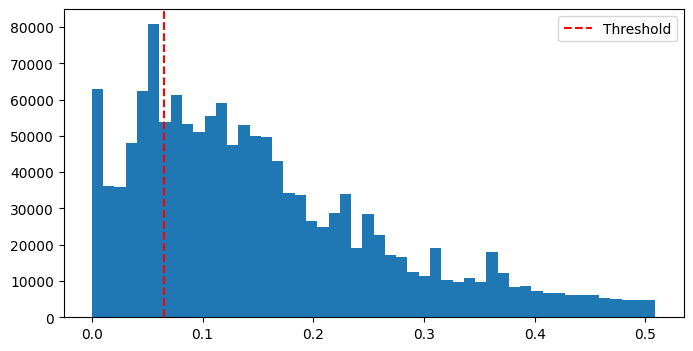

In [225]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8,4))
plt.hist(engergy_demand_copy['KWH_per_hh_mad'],bins=50)
plt.axvline(x =percentile_25, color = 'r', label = 'Threshold',linestyle='--')
plt.legend();

In [226]:
total_count = len(engergy_demand_copy)
below_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] < percentile_25])
above_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] >= percentile_25])

below_threshold_percentage = (below_threshold_count / total_count) * 100
above_threshold_percentage = (above_threshold_count / total_count) * 100

print(f"Percentage of data below the threshold: {below_threshold_percentage:.2f}%")
print(f"Percentage of data above the threshold: {above_threshold_percentage:.2f}%")


Percentage of data below the threshold: 24.77%
Percentage of data above the threshold: 75.23%


In [227]:
engergy_demand_copy['KWH_per_hh_mad']=np.where(engergy_demand_copy['KWH_per_hh_mad'] < percentile_25,0,engergy_demand_copy['KWH_per_hh_mad'])

In [228]:
total_cost=(engergy_demand_copy['Price']*engergy_demand_copy['KWH_per_hh_mad']).sum()
total_consumption=engergy_demand_copy['KWH_per_hh_mad'].sum()
print(f"Total Cost After cuttoff: {total_cost}")
print(f'Total Consumption After cuttoff: {total_consumption}')


Total Cost After cuttoff: 4276230.34755
Total Consumption After cuttoff: 201922.64549999998


In [229]:
print(f"Saving Cost: {total_cost_org-total_cost}")
print(f"Saving Energy: {total_consumption_org-total_consumption}")


Saving Cost: 239544.9744249964
Saving Energy: 11720.263999999966


In [230]:
low_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Low') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
high_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'High') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
normal_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Normal') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])

print(f"Low Demand Count: {low_count}")
print(f"High Demand Count: {high_count}")
print(f"Normal Demand Count: {normal_count}")

Low Demand Count: 32809
High Demand Count: 13010
Normal Demand Count: 297037


In [231]:
print(f"Number of new shutdown cells: {low_count-low_count_org}")
print(f"Number of new shutdown cells: {high_count-high_count_org}")
print(f"Number of new shutdown cells: {normal_count-normal_count_org}")

Number of new shutdown cells: 28363
Number of new shutdown cells: 11091
Number of new shutdown cells: 256748


In [232]:
demand_KWH_total=engergy_demand_copy.pivot_table(index='Demand',values='KWH_per_hh_mad',aggfunc='median')
demand_KWH_total

,KWH_per_hh_mad
Demand,
High,0.147
Low,0.127
Normal,0.128


In [233]:
demand_KWH_total=engergy_demand_copy.pivot_table(index='Demand',values='Cost',aggfunc='median')
demand_KWH_total

,Cost
Demand,
High,11.34987
Low,0.87503
Normal,2.49088


In [234]:
site_KWH=engergy_demand_copy.pivot_table(index='Site_ID',values='KWH_per_hh_mad',aggfunc='median')
site_KWH

,KWH_per_hh_mad
Site_ID,
A,0.199
C,0.309
D,0.158
E,0.112
F,0.123
G,0.147
H,0.161
J,0.135
K,0.129


#### The above using thresholding technique other way is by using manual from data

In [235]:
engergy_demand_copy=engergy_demand.copy()


In [236]:
def calculate_mode(series:pd.Series)->float:
    '''
    This Functions aims to return the mode

    Args:
        - df : Pandas Series
    Return:
        - Returns a Float
    '''
    return series.mode().iloc[0]

In [237]:
df_filtered = engergy_demand[(engergy_demand['KWH_per_hh_mad'] > 0)&(engergy_demand['Demand']=='Low')]

# Find the most common usage (mode)
most_common_usage = df_filtered['KWH_per_hh_mad'].mode()[0]

# Optional: Find the most common usage per hour
common_usage_by_hour = df_filtered.groupby('Hour')['KWH_per_hh_mad'].apply(calculate_mode)
# Print results
print(f"The most common usage across all hours is: {most_common_usage}")
print("The most common usage per hour:")
print(common_usage_by_hour)

The most common usage across all hours is: 0.157
The most common usage per hour:
Hour
0     0.051
1     0.051
2     0.051
3     0.051
4     0.051
5     0.122
6     0.122
7     0.359
8     0.359
9     0.107
10    0.227
11    0.157
12    0.121
13    0.250
14    0.111
15    0.157
16    0.157
17    0.250
18    0.225
19    0.121
20    0.121
21    0.359
22    0.173
23    0.173
Name: KWH_per_hh_mad, dtype: float64


#### we will use the most common number in hours

In [238]:
    threshold=common_usage_by_hour.mode()[0]
    threshold

0.051

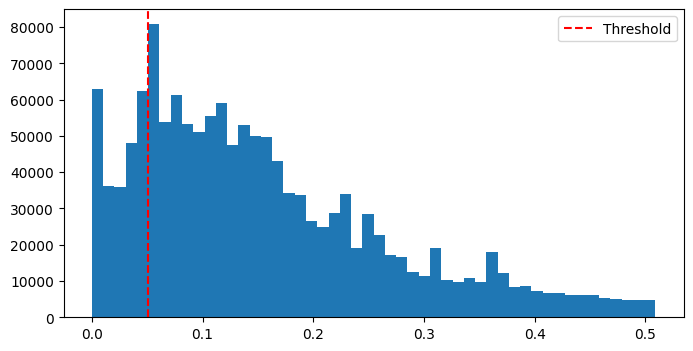

In [239]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8,4))
plt.hist(engergy_demand_copy['KWH_per_hh_mad'],bins=50)
plt.axvline(x =threshold, color = 'r', label = 'Threshold',linestyle='--')
plt.legend();

In [240]:
total_count = len(engergy_demand_copy)
below_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] < threshold])
above_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] >= threshold])

below_threshold_percentage = (below_threshold_count / total_count) * 100
above_threshold_percentage = (above_threshold_count / total_count) * 100

print(f"Percentage of data below the threshold: {below_threshold_percentage:.2f}%")
print(f"Percentage of data above the threshold: {above_threshold_percentage:.2f}%")


Percentage of data below the threshold: 17.74%
Percentage of data above the threshold: 82.26%


In [241]:
engergy_demand_copy['KWH_per_hh_mad']=np.where(engergy_demand_copy['KWH_per_hh_mad'] < threshold,0,engergy_demand_copy['KWH_per_hh_mad'])


In [242]:
total_cost=(engergy_demand_copy['Price']*engergy_demand_copy['KWH_per_hh_mad']).sum()
total_consumption=engergy_demand_copy['KWH_per_hh_mad'].sum()
print(f"Total Cost before cuttoff: {total_cost}")
print(f'Total Consumption before cuttoff: {total_consumption}')


Total Cost before cuttoff: 4389552.102635001
Total Consumption before cuttoff: 207456.03249999997


In [243]:
print(f"Saving Cost: {total_cost_org-total_cost}")
print(f"Saving Energy: {total_consumption_org-total_consumption}")


Saving Cost: 126223.21933999564
Saving Energy: 6186.876999999979


In [244]:
low_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Low') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
high_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'High') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
normal_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Normal') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])

print(f"Low Demand Count: {low_count}")
print(f"High Demand Count: {high_count}")
print(f"Normal Demand Count: {normal_count}")

Low Demand Count: 23468
High Demand Count: 9271
Normal Demand Count: 212769


In [245]:
print(f"Number of new shutdown cells: {low_count-low_count_org}")
print(f"Number of new shutdown cells: {high_count-high_count_org}")
print(f"Number of new shutdown cells: {normal_count-normal_count_org}")


Number of new shutdown cells: 19022
Number of new shutdown cells: 7352
Number of new shutdown cells: 172480


In [246]:
demand_KWH_total=engergy_demand_copy.pivot_table(index='Demand',values='KWH_per_hh_mad',aggfunc='sum')
demand_KWH_total

,KWH_per_hh_mad
Demand,
High,10343.2625
Low,19480.1670
Normal,177632.6030


In [247]:
site_KWH=engergy_demand_copy.pivot_table(index='Site_ID',values='KWH_per_hh_mad',aggfunc='mean')
site_KWH

,KWH_per_hh_mad
Site_ID,
A,0.231359
C,0.317785
D,0.170039
E,0.130357
F,0.153917
G,0.169800
H,0.174709
J,0.152149
K,0.149871


In [248]:
engergy_demand_copy=engergy_demand.copy()

#### Another approach is to use least value in median in sites which is 0.057

In [249]:
threshold=0.057

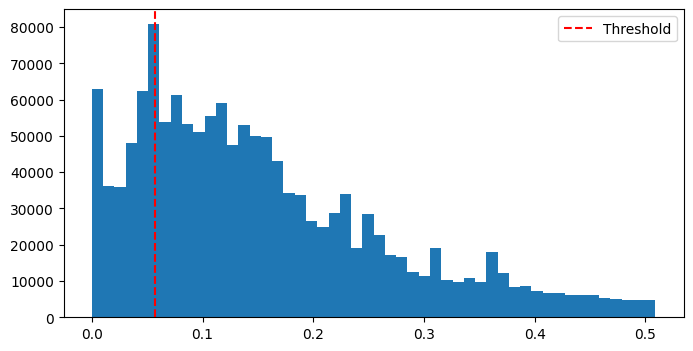

In [250]:
# peform histogram to see the spread of the data
plt.figure(figsize=(8,4))
plt.hist(engergy_demand_copy['KWH_per_hh_mad'],bins=50)
plt.axvline(x =threshold, color = 'r', label = 'Threshold',linestyle='--')
plt.legend();

In [251]:
total_count = len(engergy_demand_copy)
below_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] < threshold])
above_threshold_count = len(engergy_demand_copy[engergy_demand_copy['KWH_per_hh_mad'] >= threshold])

below_threshold_percentage = (below_threshold_count / total_count) * 100
above_threshold_percentage = (above_threshold_count / total_count) * 100

print(f"Percentage of data below the threshold: {below_threshold_percentage:.2f}%")
print(f"Percentage of data above the threshold: {above_threshold_percentage:.2f}%")

Percentage of data below the threshold: 21.27%
Percentage of data above the threshold: 78.73%


In [252]:
engergy_demand_copy['KWH_per_hh_mad']=np.where(engergy_demand_copy['KWH_per_hh_mad'] < threshold,0,engergy_demand_copy['KWH_per_hh_mad'])


In [253]:
total_cost=(engergy_demand_copy['Price']*engergy_demand_copy['KWH_per_hh_mad']).sum()
total_consumption=engergy_demand_copy['KWH_per_hh_mad'].sum()
print(f"Total Cost before cuttoff: {total_cost}")
print(f'Total Consumption before cuttoff: {total_consumption}')


Total Cost before cuttoff: 4336258.5169250015
Total Consumption before cuttoff: 204844.74849999984


In [254]:
print(f"Saving Cost: {total_cost_org-total_cost}")
print(f"Saving Energy: {total_consumption_org-total_consumption}")

Saving Cost: 179516.80504999496
Saving Energy: 8798.16100000011


In [255]:
low_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Low') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
high_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'High') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])
normal_count = len(engergy_demand_copy[(engergy_demand_copy['Demand'] == 'Normal') & (engergy_demand_copy['KWH_per_hh_mad'] == 0)])

print(f"Low Demand Count: {low_count}")
print(f"High Demand Count: {high_count}")
print(f"Normal Demand Count: {normal_count}")

Low Demand Count: 28225
High Demand Count: 11106
Normal Demand Count: 255058


In [256]:
print(f"Number of new shutdown cells: {low_count-low_count_org}")
print(f"Number of new shutdown cells: {high_count-high_count_org}")
print(f"Number of new shutdown cells: {normal_count-normal_count_org}")

Number of new shutdown cells: 23779
Number of new shutdown cells: 9187
Number of new shutdown cells: 214769


In [257]:
site_KWH=engergy_demand_copy.pivot_table(index='Site_ID',values='KWH_per_hh_mad',aggfunc='mean')
site_KWH

,KWH_per_hh_mad
Site_ID,
A,0.231008
C,0.317785
D,0.169481
E,0.128396
F,0.151582
G,0.168830
H,0.173535
J,0.150563
K,0.149070


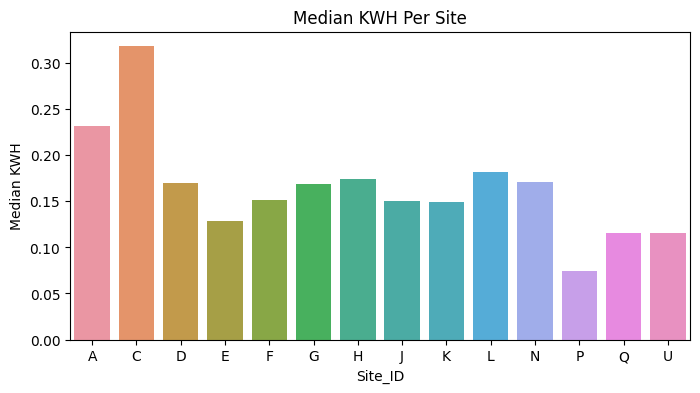

In [258]:
plt.figure(figsize=(8,4))
sns.barplot(x=site_KWH.index,y=site_KWH['KWH_per_hh_mad'])
plt.ylabel('Median KWH')
plt.title('Median KWH Per Site');

In [259]:
demand_cost_Region=engergy_demand_copy.pivot_table(index='Demand',columns='Site_ID',values='Cost',aggfunc='median')
demand_cost_Region

Site_ID,A,C,D,E,F,G,H,J,K,L,N,P,Q,U
Demand,,,,,,,,,,,,,,
High,17.140620,23.85789,12.50802,9.96009,10.925215,12.35360,14.43827,11.73592,11.11824,16.36852,14.36106,4.55539,9.03357,8.72473
Low,1.353885,2.12901,1.08173,0.81302,0.833690,1.02661,1.08173,0.92326,0.84747,1.07484,0.97149,0.38584,0.65455,0.67522
Normal,3.853080,6.01314,3.07468,2.16006,2.393580,2.84116,3.11360,2.58818,2.49088,3.07468,2.86062,1.10922,1.88762,1.94600


After analyzing the data, three potential cutoff values were identified for cell shutdowns during low-demand periods. Here’s a breakdown of each option and their impact:  

#### 1. **Cutoff at 0.065 (25th Percentile)**  
   - **Impact on Data:** This cutoff removes approximately 24.77% of the data.  
   - **Savings:**  
     - **Cost:** Saves **239,544.97** in cost.  
     - **Energy:** Saves **11,720.264** in power consumption.  
   - **Shutdown Details:**  
     - Low demand: **28,363 cells/timings**  
     - High demand: **11,091 cells/timings**  
     - Normal demand: **256,748 cells/timings**  
   - **When to Use:**  
     - If the goal is to maximize cost and energy savings across all demand scenarios.  

#### 2. **Cutoff at 0.051 (Most Frequent Value in Hours in Low Demand)**  
   - **Impact on Data:** This cutoff removes approximately 17.74% of the data.  
   - **Savings:**  
     - **Cost:** Saves **126,223.22** in cost.  
     - **Energy:** Saves **6,186.88** in power consumption.  
   - **Shutdown Details:**  
     - Low demand: **19,022 cells/timings**  
     - High demand: **7,352 cells/timings**  
     - Normal demand: **172,480 cells/timings**  
   - **When to Use:**  
     - If you want a more conservative approach that prioritizes retaining more data.  
     - Useful in cases where stability is key, and the most frequent usage pattern aligns with operational objectives.  

#### 3. **Cutoff at 0.057 (Lowest Median Across Sites)**  
   - **Impact on Data:** This cutoff removes approximately 21.27% of the data.  
   - **Savings:**  
     - **Cost:** Saves **179,516.81** in cost.  
     - **Energy:** Saves **8,798.16** in power consumption.  
   - **Shutdown Details:**  
     - Low demand: **23,779 cells/timings**  
     - High demand: **9,187 cells/timings**  
     - Normal demand: **214,769 cells/timings**  
   - **When to Use:**  
     - If the aim is to balance savings and data retention by considering the lowest energy demand across sites. (This provides a balance between the two values above.)  

---

### Choosing the Right Cutoff Value  
- **For maximum cost and energy savings:** Choose **0.065**.  
- **For a safe choice that keeps things stable:** Choose **0.051**.  
- **For a balanced approach:** Choose **0.057**.  

## Insights

### Business Insights  

1. **Regional and Site-Based Energy Consumption:**  
   - **Insight:** Energy consumption varies significantly between regions and sites, with the highest consumption observed in Region **C** and Site **C**, and the lowest in Region **D** and Site **P**.  
   - **Action:** Focus energy-saving measures on high-consumption regions and sites, such as **C**, to maximize cost efficiency and raise awareness about saving electricity.  

2. **Time-Based Energy Usage:**  
   - **Insight:** Energy usage differs by time category (low, normal, high demand). Higher usage occurs during peak times, while low-demand times present opportunities for savings.  
   - **Action:** Schedule shutdowns or reductions during low-demand periods to save costs without compromising performance during high-demand times.  

3. **Cost vs. Demand Dynamics:**  
   - **Insight:** Energy cost aligns with demand levels, with the highest costs during high demand and the lowest during low demand.  
   - **Action:** Optimize energy usage during high-cost periods by shutting down low-priority cells.  

4. **Weekend vs. Weekday Patterns:**  
   - **Insight:** Energy consumption patterns are similar between weekends and weekdays, indicating potential optimization opportunities regardless of the day.  
   - **Action:** Implement uniform strategies across all days to simplify management and reduce costs.  

5. **Threshold Selection for Savings:**  
   - **Insight:** Different thresholds for cell shutdown yield varying levels of cost and energy savings. For example, the 25th percentile cutoff (0.065) saves the most energy and costs.  
   - **Action:** Choose thresholds that align with business priorities—maximum savings, minimal disruption, or balanced trade-offs.  

This script checks for missing date-time records in a dataset where each unique `Cell_ID` is expected to have 17,520 half-hour intervals, covering an entire year. Here's an explanation of the need and the logic behind it:

---

### **Purpose of the Script:**

1. **Data Completeness Validation:**
   - Each `Cell_ID` is expected to have data points for all 17,520 half-hour intervals in a year (`365 days × 24 hours × 2 intervals/hour`).
   - The script identifies `DateTime` records that are missing for each `Cell_ID`.

2. **Maintain Data Integrity:**
   - Missing intervals can affect downstream analyses like time series modeling, forecasting, or trend analysis.
   - Filling or analyzing missing data ensures consistent data quality.

---

### **How the Code Works:**

1. **Define the DateTime Format:**
   - `format = '%Y-%m-%d %H:%M:%S'` ensures consistency in handling `DateTime` strings.

2. **Identify Unique Cells:**
   - The script loops through each unique `Cell_ID` in the dataset (`df_combined_copy['Cell_ID'].unique()`).

3. **Initialize Storage for Missing Dates:**
   - A dictionary `missing_dates` is created to store missing intervals for each `Cell_ID`.

4. **Generate Half-Hour Intervals:**
   - Starting from `2013-01-01 00:00:00`, the code computes subsequent half-hour intervals using `datetime.timedelta(minutes=x*30)`.

5. **Check for Missing Dates:**
   - For each `Cell_ID`, the script compares the generated intervals against the available `DateTime` records in the data (`cell_data['DateTime']`).
   - If a computed interval is not found, it is added to the list of missing intervals for that `Cell_ID`.

---

### **Issues and Potential Improvements:**

1. **Efficiency Concerns:**
   - The nested loop structure (`for cell in cells` and `for x in range(17520)`) can be computationally expensive for large datasets.
   - Optimization can be achieved using vectorized operations or external libraries like NumPy.

2. **Incorrect DateTime Comparison:**
   - The `if not (cell_data['DateTime'] == new_date)` line may not work as intended. Instead, use `.isin()` to check membership in the dataset:
     ```python
     if new_date not in cell_data['DateTime'].values:
     ```

3. **Memory Usage:**
   - Storing all 17,520 intervals for each `Cell_ID` may consume significant memory. Filtering the dataset in chunks can help manage resources.

4. **Scalability:**
   - The script may not scale well for datasets spanning multiple years or with many `Cell_ID`s. Consider parallelizing the computation.

---

### **Why is This Needed?**

1. **Data Accuracy:**
   - Ensures that analyses reflect the full data range without distortions caused by missing intervals.

2. **Predictive Modeling:**
   - Missing intervals could disrupt models like ARIMA, which depend on evenly spaced time-series data.

3. **Reporting and Compliance:**
   - In domains like energy monitoring, telecom, or IoT, complete records are essential for compliance and accurate reporting.

By identifying and potentially imputing missing intervals, the script aligns the dataset with these requirements.